In [1]:
import sys
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib.ticker as ticker
import numpy as np
import torch

# Disable cudnn
from torch.backends import cudnn
cudnn.enabled = False

from spice import pipeline_rnn_autoreg
from spice.resources.old_rnn import RLRNN_dezfouli2019, RLRNN_eckstein2022 # Get predefined RNN architectures

# Setting seeds for reproducibility
np.random.seed(186)
torch.manual_seed(186)

Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.
Library setup is valid. All keys and features appear in the provided list of features.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set most important arguments:
dataset = 'eckstein2022'  # 'eckstein2022' or 'dezfouli2019'
epochs = 8192
metaopt_type = 'imaml'

# AWD
lambda_awd = 1e-1

# iMAML
initial_reg_param = 1e-4
outer_lr = 1e-1

# Fixed model path name
if metaopt_type == 'awd':
    path_model = f'params/{dataset}/AWD_{dataset}_ep{epochs}_lawd-{lambda_awd:.0e}_rnn.pkl'
elif metaopt_type == 'imaml':
    path_model = f'params/{dataset}/iMAML_{dataset}_ep{epochs}_metalr-{outer_lr:.0e}_in-{initial_reg_param:.0e}_rnn.pkl'
else:
    raise ValueError('metaopt_type must be either "awd" or "imaml"')

# SPICE config
path_data = f'../data/{dataset}/{dataset}.csv'
additional_inputs = None

if dataset == 'eckstein2022':
    train_test_ratio = 0.8
    class_rnn = RLRNN_eckstein2022
elif dataset == 'dezfouli2019':
    train_test_ratio = [3, 6, 9]
    class_rnn = RLRNN_dezfouli2019
else:
    raise ValueError('Dataset must be either "eckstein2022" or "dezfouli2019"')


In [ ]:
model, _, histories = pipeline_rnn_autoreg.main(
    
    dropout=0.25,
    train_test_ratio=train_test_ratio,
    
    # general training parameters
    checkpoint=False,
    epochs=epochs, # <- 2^16
    scheduler=True,
    learning_rate=1e-2, # 1e-2

    # Meta-optimization parameters
    metaopt_type=metaopt_type,

    lambda_awd=lambda_awd,

    meta_update_interval=50,
    inner_steps=3,
    outer_lr=outer_lr,
    hypergradient_steps=3,
    initial_reg_param=initial_reg_param,

    # hand-picked params
    n_steps=-1,
    embedding_size=32,
    batch_size=-1,
    sequence_length=-1,
    bagging=True,
    
    class_rnn=class_rnn,
    model=path_model,
    data=path_data,
    additional_inputs_data=additional_inputs,
    
    # synthetic dataset parameters
    n_sessions=128,
    n_trials=200,
    sigma=0.2,
    beta_reward=3.,
    alpha_reward=0.25,
    alpha_penalty=0.5,
    forget_rate=0.,
    confirmation_bias=0.,
    beta_choice=0.,
    alpha_choice=1.,
    counterfactual=False,
    alpha_counterfactual=0.,
    
    save_checkpoints=True,
    analysis=False,
    participant_id=0,
    )

Cuda available: False
Setup of the RNN model complete.
Training the RNN...
Using Implicit MAML (iMAML) for meta-optimization.
Epoch 1/8192 --- L(Train): 0.6725; L(Val): 0.5252; Reg Param: 0.0001; Time: 2.59
Epoch 2/8192 --- L(Train): 0.5263; L(Val): 0.5161; Reg Param: 0.0001; Time: 1.11
Epoch 3/8192 --- L(Train): 0.5259; L(Val): 0.5083; Reg Param: 0.0001; Time: 1.42
Epoch 4/8192 --- L(Train): 0.5154; L(Val): 0.5016; Reg Param: 0.0001; Time: 1.12
Epoch 5/8192 --- L(Train): 0.5090; L(Val): 0.4958; Reg Param: 0.0001; Time: 1.04
Epoch 6/8192 --- L(Train): 0.5094; L(Val): 0.4906; Reg Param: 0.0001; Time: 0.91
Epoch 7/8192 --- L(Train): 0.5007; L(Val): 0.4858; Reg Param: 0.0001; Time: 0.92
Epoch 8/8192 --- L(Train): 0.4907; L(Val): 0.4815; Reg Param: 0.0001; Time: 0.94
Epoch 9/8192 --- L(Train): 0.4883; L(Val): 0.4776; Reg Param: 0.0001; Time: 0.92
Epoch 10/8192 --- L(Train): 0.4788; L(Val): 0.4743; Reg Param: 0.0001; Time: 0.92
Epoch 11/8192 --- L(Train): 0.4700; L(Val): 0.4715; Reg Param: 

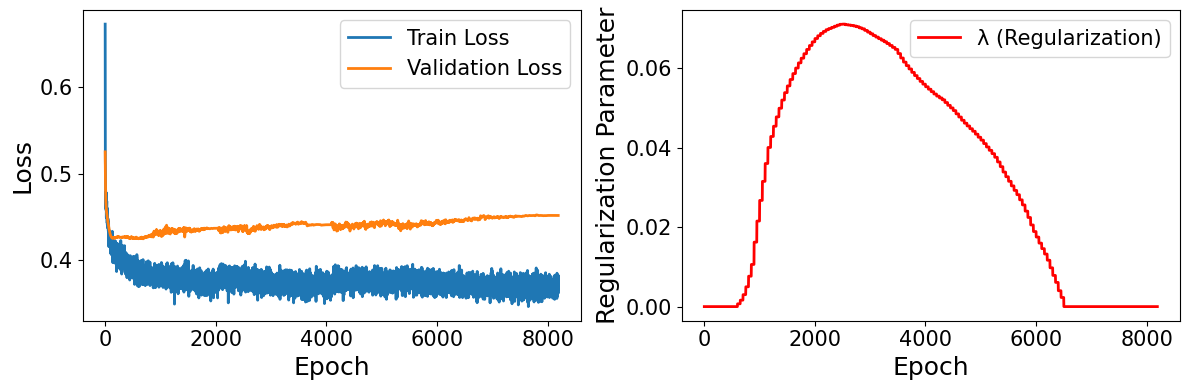

In [4]:
train_loss_history, val_loss_history, reg_history = histories
plot_epochs = np.arange(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 4))

# Plot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(plot_epochs, train_loss_history, label="Train Loss", linewidth=2)
plt.plot(plot_epochs, val_loss_history, label="Validation Loss", linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)


if metaopt_type == 'awd':
    # Subplot 2: lambda weight decay
    plt.subplot(1,2,2)
    plt.plot(plot_epochs, reg_history, label='λ weight decay')
    plt.xlabel('Epoch')
    plt.ylabel('λ weight decay')
    plt.legend()
    plt.grid(True, alpha=0.3)
elif metaopt_type == 'imaml':
    # Plot 2: Regularization parameter
    plt.subplot(1, 2, 2)
    plt.plot(plot_epochs, reg_history, label="λ (Regularization)", linewidth=2, color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Regularization Parameter')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [5]:
# Set Configs
from spice.resources import sindy_utils
sindy_config = sindy_utils.SindyConfig_eckstein2022 if dataset == 'eckstein2022' else sindy_utils.SindyConfig_dezfouli2019

In [6]:
### SINDy
from spice import pipeline_sindy

agent_spice, features, sindy_loss = pipeline_sindy.main(
    class_rnn=class_rnn,
    model = path_model,
    data = path_data,
    additional_inputs_data=additional_inputs,
    save = True,
    
    # general recovery parameters
    participant_id=None,
    filter_bad_participants=False,
    use_optuna=True,
    pruning=False,
    
    # sindy parameters
    train_test_ratio=train_test_ratio,
    polynomial_degree=3,
    optimizer_alpha=0.1,
    optimizer_threshold=0.05, # 0.05
    n_trials_off_policy=1000,
    n_sessions_off_policy=1,
    n_trials_same_action_off_policy=5,
    optuna_threshold=0.1, # 0.1
    optuna_n_trials=50, # 50
    optimizer_type='SR3_weighted_l1',  # 'STLSQ',  'SR3_weighted_l1'
    # optimizer_type='SR3_L1',
    verbose=False,
    
    # generated training dataset parameters
    n_actions=2,
    sigma=0.2,
    beta_reward=1.,
    alpha=0.25,
    alpha_penalty=0.25,
    forget_rate=0.,
    confirmation_bias=0.,
    beta_choice=1.,
    alpha_choice=1.,
    counterfactual=False,
    alpha_counterfactual=0.,
    
    analysis=True,
    get_loss=False,
    
    **sindy_config,
)

Library setup is valid. All keys and features appear in the provided list of features.
[tensor(0.), tensor(1.)]


  0%|          | 0/306 [00:00<?, ?it/s]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 12:12:16,969] A new study created in memory with name: no-name-f494d10c-bb91-4641-a09a-f7b0adf5d0f2


Likelihoods before optuna fitting: RNN = 0.77922; SPICE =  0.00664; Diff = 0.77258
Using optuna to find a better set of pysindy parameters for participant 0...


                                       
  0%|          | 0/306 [00:07<?, ?it/s]

[I 2025-09-26 12:12:20,374] Trial 0 finished with value: 0.048863064833393414 and parameters: {'optimizer_alpha': 0.025189539243336268, 'optimizer_threshold': 0.19566855582819848}. Best is trial 0 with value: 0.048863064833393414.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                       
Best trial: 1. Best value: 0.00736196:   4%|▍         | 2/50 [00:06<02:44,  3.42s/it, 6.83/600 seconds]


[I 2025-09-26 12:12:23,797] Trial 1 finished with value: 0.007361958063317657 and parameters: {'optimizer_alpha': 0.0804538158263467, 'optimizer_threshold': 0.049336296766759255}. Best is trial 1 with value: 0.007361958063317657.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  0%|          | 1/306 [00:13<1:10:37, 13.89s/it]

Likelihoods after optuna fitting: RNN = 0.77922; SPICE =  0.00664 -> 0.76791, Diff = 0.77258 -> 0.01131


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  1%|          | 2/306 [00:17<40:35,  8.01s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  1%|          | 3/306 [00:21<30:48,  6.10s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  2%|▏         | 5/306 [00:29<23:47,  4.74s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  

Likelihoods before optuna fitting: RNN = 0.76812; SPICE =  8e-05; Diff = 0.76804
Using optuna to find a better set of pysindy parameters for participant 6...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [00:40<22:10,  4.44s/it]

[I 2025-09-26 12:12:53,990] Trial 0 finished with value: 2.035845167017313 and parameters: {'optimizer_alpha': 0.015079100506233222, 'optimizer_threshold': 0.07007911018776107}. Best is trial 0 with value: 2.035845167017313.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [00:44<22:10,  4.44s/it]                                                     

[I 2025-09-26 12:12:57,621] Trial 1 finished with value: 0.6960262441711608 and parameters: {'optimizer_alpha': 0.07673734758100885, 'optimizer_threshold': 0.013263805677931942}. Best is trial 1 with value: 0.6960262441711608.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [00:47<22:10,  4.44s/it]                                                      

[I 2025-09-26 12:13:01,222] Trial 2 finished with value: 1.5652531858629817 and parameters: {'optimizer_alpha': 0.03636012165612374, 'optimizer_threshold': 0.030820582880643}. Best is trial 1 with value: 0.6960262441711608.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [00:51<22:10,  4.44s/it]                                                       

[I 2025-09-26 12:13:04,834] Trial 3 finished with value: 0.5897567733500266 and parameters: {'optimizer_alpha': 0.13178673810934272, 'optimizer_threshold': 0.09583541437996174}. Best is trial 3 with value: 0.5897567733500266.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [00:55<22:10,  4.44s/it]                                                       

[I 2025-09-26 12:13:08,543] Trial 4 finished with value: 0.03378759035712445 and parameters: {'optimizer_alpha': 0.3950515540538052, 'optimizer_threshold': 0.19457024584357974}. Best is trial 4 with value: 0.03378759035712445.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [00:58<22:10,  4.44s/it]                                                        

[I 2025-09-26 12:13:12,149] Trial 5 finished with value: 21.565361377057705 and parameters: {'optimizer_alpha': 0.14615375926457494, 'optimizer_threshold': 0.039494026548203824}. Best is trial 4 with value: 0.03378759035712445.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:02<22:10,  4.44s/it]                                                        

[I 2025-09-26 12:13:15,758] Trial 6 finished with value: 1.4926032425619689 and parameters: {'optimizer_alpha': 0.9308110404183011, 'optimizer_threshold': 0.03265183338119}. Best is trial 4 with value: 0.03378759035712445.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:06<22:10,  4.44s/it]                                                        

[I 2025-09-26 12:13:19,363] Trial 7 finished with value: 1.9933252360196025 and parameters: {'optimizer_alpha': 0.030327288041148277, 'optimizer_threshold': 0.015213782859333867}. Best is trial 4 with value: 0.03378759035712445.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:09<22:10,  4.44s/it]                                                        

[I 2025-09-26 12:13:22,972] Trial 8 finished with value: 0.0490571343004372 and parameters: {'optimizer_alpha': 0.10069711602915182, 'optimizer_threshold': 0.05073715197019729}. Best is trial 4 with value: 0.03378759035712445.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:13<22:10,  4.44s/it]                                                        

[I 2025-09-26 12:13:26,590] Trial 9 finished with value: 1.5360821976325603 and parameters: {'optimizer_alpha': 0.07265740486224845, 'optimizer_threshold': 0.01368859334041275}. Best is trial 4 with value: 0.03378759035712445.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:16<22:10,  4.44s/it]                                                         

[I 2025-09-26 12:13:30,220] Trial 10 finished with value: 1.5919756005050534 and parameters: {'optimizer_alpha': 0.5520414396059656, 'optimizer_threshold': 0.19823404954181548}. Best is trial 4 with value: 0.03378759035712445.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:20<22:10,  4.44s/it]                                                         

[I 2025-09-26 12:13:33,871] Trial 11 finished with value: 0.27209173923170293 and parameters: {'optimizer_alpha': 0.3428578278524634, 'optimizer_threshold': 0.17958355236190718}. Best is trial 4 with value: 0.03378759035712445.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:24<22:10,  4.44s/it]                                                         

[I 2025-09-26 12:13:37,506] Trial 12 finished with value: 0.014630736271494166 and parameters: {'optimizer_alpha': 0.2751074312654128, 'optimizer_threshold': 0.0920622741654194}. Best is trial 12 with value: 0.014630736271494166.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:27<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:13:41,210] Trial 13 finished with value: 2.5246590632053487 and parameters: {'optimizer_alpha': 0.2572096576480573, 'optimizer_threshold': 0.11731613976884823}. Best is trial 12 with value: 0.014630736271494166.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:31<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:13:44,810] Trial 14 finished with value: 0.12535804408863996 and parameters: {'optimizer_alpha': 0.29656117218537886, 'optimizer_threshold': 0.12526968238832847}. Best is trial 12 with value: 0.014630736271494166.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:35<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:13:48,420] Trial 15 finished with value: 0.9760792922554413 and parameters: {'optimizer_alpha': 0.7062770348103323, 'optimizer_threshold': 0.0746254823426102}. Best is trial 12 with value: 0.014630736271494166.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:38<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:13:52,056] Trial 16 finished with value: 0.013970398049108287 and parameters: {'optimizer_alpha': 0.44250400846182975, 'optimizer_threshold': 0.14815437192531677}. Best is trial 16 with value: 0.013970398049108287.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:42<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:13:55,790] Trial 17 finished with value: 10.212322555254332 and parameters: {'optimizer_alpha': 0.20526756391527354, 'optimizer_threshold': 0.12932581171476312}. Best is trial 16 with value: 0.013970398049108287.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:46<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:13:59,443] Trial 18 finished with value: 1.947071370246824 and parameters: {'optimizer_alpha': 0.6084002242518808, 'optimizer_threshold': 0.06386794416602211}. Best is trial 16 with value: 0.013970398049108287.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:49<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:03,070] Trial 19 finished with value: 0.9906726701240773 and parameters: {'optimizer_alpha': 0.19271842345218668, 'optimizer_threshold': 0.09731386948948563}. Best is trial 16 with value: 0.013970398049108287.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:53<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:06,709] Trial 20 finished with value: 1.503123029025419 and parameters: {'optimizer_alpha': 0.4133033009795356, 'optimizer_threshold': 0.1523603580272385}. Best is trial 16 with value: 0.013970398049108287.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [01:57<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:10,333] Trial 21 finished with value: 2.5027903655566335 and parameters: {'optimizer_alpha': 0.47063147522026344, 'optimizer_threshold': 0.19652513892195822}. Best is trial 16 with value: 0.013970398049108287.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:00<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:14,048] Trial 22 finished with value: 2.242689846907126 and parameters: {'optimizer_alpha': 0.9469262411780556, 'optimizer_threshold': 0.09668623175815007}. Best is trial 16 with value: 0.013970398049108287.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:04<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:17,676] Trial 23 finished with value: 0.010851874190367752 and parameters: {'optimizer_alpha': 0.3235915081357131, 'optimizer_threshold': 0.14940858661849765}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:07<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:21,306] Trial 24 finished with value: 2.1073902173715306 and parameters: {'optimizer_alpha': 0.23224713076320075, 'optimizer_threshold': 0.14113078591971878}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:11<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:24,923] Trial 25 finished with value: 0.013861509651637634 and parameters: {'optimizer_alpha': 0.1479891001264405, 'optimizer_threshold': 0.07968227185073018}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:15<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:28,551] Trial 26 finished with value: 0.3570083914017418 and parameters: {'optimizer_alpha': 0.043798108676616716, 'optimizer_threshold': 0.04897332792278228}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:18<22:10,  4.44s/it]                                                          

[I 2025-09-26 12:14:32,226] Trial 27 finished with value: 0.4150622582602568 and parameters: {'optimizer_alpha': 0.15068116437737542, 'optimizer_threshold': 0.021069069759887926}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:22<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:14:35,862] Trial 28 finished with value: 3.700050355115361 and parameters: {'optimizer_alpha': 0.010125396456408323, 'optimizer_threshold': 0.14965764093394637}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:26<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:14:39,515] Trial 29 finished with value: 0.021500070794233023 and parameters: {'optimizer_alpha': 0.06781758457841666, 'optimizer_threshold': 0.06777839473146435}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:29<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:14:43,243] Trial 30 finished with value: 6.668026816313167 and parameters: {'optimizer_alpha': 0.10233334409715053, 'optimizer_threshold': 0.08055414166939011}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:33<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:14:46,875] Trial 31 finished with value: 0.012306646964187188 and parameters: {'optimizer_alpha': 0.3134928919385464, 'optimizer_threshold': 0.11111169108409244}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:37<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:14:50,525] Trial 32 finished with value: 8.859098607095596 and parameters: {'optimizer_alpha': 0.16713223047270645, 'optimizer_threshold': 0.1190935358564942}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:40<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:14:54,157] Trial 33 finished with value: 1.3672626103133585 and parameters: {'optimizer_alpha': 0.3430934336967171, 'optimizer_threshold': 0.059423878131347196}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:44<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:14:57,891] Trial 34 finished with value: 1.871780348204673 and parameters: {'optimizer_alpha': 0.4661231607529604, 'optimizer_threshold': 0.16281815400583297}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:48<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:01,523] Trial 35 finished with value: 2.204862952529205 and parameters: {'optimizer_alpha': 0.7316356984974135, 'optimizer_threshold': 0.10172646642443986}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:51<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:05,151] Trial 36 finished with value: 19.91545672873138 and parameters: {'optimizer_alpha': 0.1302056779764424, 'optimizer_threshold': 0.08010925746558807}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:55<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:08,792] Trial 37 finished with value: 0.012688238110828287 and parameters: {'optimizer_alpha': 0.33833885723347695, 'optimizer_threshold': 0.15946954198760302}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [02:59<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:12,482] Trial 38 finished with value: 7.426099812303505 and parameters: {'optimizer_alpha': 0.05227009128819198, 'optimizer_threshold': 0.010095886094837843}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:02<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:16,231] Trial 39 finished with value: 2.3859965006114248 and parameters: {'optimizer_alpha': 0.027515950948078804, 'optimizer_threshold': 0.11091125291952965}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:06<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:19,849] Trial 40 finished with value: 6.992818504507741 and parameters: {'optimizer_alpha': 0.11179437613094015, 'optimizer_threshold': 0.17328370434354354}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:10<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:23,527] Trial 41 finished with value: 1.2871904348774132 and parameters: {'optimizer_alpha': 0.33166358620038944, 'optimizer_threshold': 0.14287345158275375}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:14<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:27,602] Trial 42 finished with value: 0.7060844007667724 and parameters: {'optimizer_alpha': 0.20516916500244292, 'optimizer_threshold': 0.13617930270410422}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:17<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:31,230] Trial 43 finished with value: 2.854592892081207 and parameters: {'optimizer_alpha': 0.5080581418342636, 'optimizer_threshold': 0.08532785805895932}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:21<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:34,909] Trial 44 finished with value: 3.9513119599965316 and parameters: {'optimizer_alpha': 0.3710623440777088, 'optimizer_threshold': 0.0369717372877945}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:25<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:38,555] Trial 45 finished with value: 0.9089855802626682 and parameters: {'optimizer_alpha': 0.6543171752341113, 'optimizer_threshold': 0.1676483188603882}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:28<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:42,253] Trial 46 finished with value: 23.016270821050785 and parameters: {'optimizer_alpha': 0.25309041035223734, 'optimizer_threshold': 0.10807138299272248}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:32<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:45,890] Trial 47 finished with value: 1.4436365706253462 and parameters: {'optimizer_alpha': 0.17213195171210402, 'optimizer_threshold': 0.05590867946285119}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
  2%|▏         | 6/306 [03:36<22:10,  4.44s/it]                                                           

[I 2025-09-26 12:15:49,643] Trial 48 finished with value: 1.0308480802153825 and parameters: {'optimizer_alpha': 0.4325425174394122, 'optimizer_threshold': 0.025566935661283523}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                               
Best trial: 23. Best value: 0.0108519: 100%|██████████| 50/50 [03:02<00:00,  3.66s/it, 182.89/600 seconds]


[I 2025-09-26 12:15:53,283] Trial 49 finished with value: 0.8998029595948016 and parameters: {'optimizer_alpha': 0.08046616863013173, 'optimizer_threshold': 0.12266883804089311}. Best is trial 23 with value: 0.010851874190367752.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  2%|▏         | 7/306 [03:43<5:24:59, 65.21s/it]

Likelihoods after optuna fitting: RNN = 0.76812; SPICE =  8e-05 -> 0.06541, Diff = 0.76804 -> 0.70271


  4%|▎         | 11/306 [03:59<1:26:46, 17.65s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  4%|▍         | 12/306 [04:02<1:05:53, 13.45s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  5%|▍         | 14/306 [04:10<41:34,  8.54s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  5%|▍         | 15/306 [04:14<34:35,  7.13s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did

Likelihoods before optuna fitting: RNN = 0.74593; SPICE =  0.66455; Diff = 0.08138
Using optuna to find a better set of pysindy parameters for participant 19...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  6%|▌         | 19/306 [04:37<22:17,  4.66s/it]

[I 2025-09-26 12:16:50,972] Trial 0 finished with value: 0.43856525435131377 and parameters: {'optimizer_alpha': 0.17538422236205378, 'optimizer_threshold': 0.018697665672913658}. Best is trial 0 with value: 0.43856525435131377.


                                                
  6%|▌         | 19/306 [04:41<22:17,  4.66s/it]                                                     

[I 2025-09-26 12:16:54,562] Trial 1 finished with value: 0.020487415155735628 and parameters: {'optimizer_alpha': 0.028883136584883874, 'optimizer_threshold': 0.11193564826080998}. Best is trial 1 with value: 0.020487415155735628.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 2. Best value: 0.00292231:   6%|▌         | 3/50 [00:10<02:50,  3.64s/it, 10.91/600 seconds]


[I 2025-09-26 12:16:58,197] Trial 2 finished with value: 0.0029223126438255977 and parameters: {'optimizer_alpha': 0.6156769180453786, 'optimizer_threshold': 0.03918067421314951}. Best is trial 2 with value: 0.0029223126438255977.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  7%|▋         | 20/306 [04:48<41:53,  8.79s/it]

Likelihoods after optuna fitting: RNN = 0.74593; SPICE =  0.66455 -> 0.7399, Diff = 0.08138 -> 0.00603


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  7%|▋         | 22/306 [04:56<29:40,  6.27s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  8%|▊         | 23/306 [05:00<26:09,  5.55s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 12:17:17,260] A new study created in memory with name: no-name-bb734720-218e-4cc9-92fb-aa15a9526c6c


Likelihoods before optuna fitting: RNN = 0.82724; SPICE =  0.79684; Diff = 0.03039
Using optuna to find a better set of pysindy parameters for participant 23...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00249511:   2%|▏         | 1/50 [00:03<03:00,  3.69s/it, 3.69/600 seconds]


[I 2025-09-26 12:17:20,944] Trial 0 finished with value: 0.0024951090668683443 and parameters: {'optimizer_alpha': 0.17477614671282762, 'optimizer_threshold': 0.10779738628331433}. Best is trial 0 with value: 0.0024951090668683443.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  8%|▊         | 24/306 [05:11<33:56,  7.22s/it]

Likelihoods after optuna fitting: RNN = 0.82724; SPICE =  0.79684 -> 0.83908, Diff = 0.03039 -> -0.01185


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  8%|▊         | 25/306 [05:15<29:05,  6.21s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  8%|▊         | 26/306 [05:18<25:42,  5.51s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
  9%|▉         | 27/306 [05:22<23:24,  5.03s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 

Likelihoods before optuna fitting: RNN = 0.89943; SPICE =  0.01177; Diff = 0.88766
Using optuna to find a better set of pysindy parameters for participant 29...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                
  9%|▉         | 29/306 [05:38<20:37,  4.47s/it]

[W 2025-09-26 12:17:51,624] Trial 0 failed with parameters: {'optimizer_alpha': 0.05042532256405286, 'optimizer_threshold': 0.051519092356700116} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:17:51,629] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                
  9%|▉         | 29/306 [05:41<20:37,  4.47s/it]                

[W 2025-09-26 12:17:55,246] Trial 1 failed with parameters: {'optimizer_alpha': 0.19771364040073652, 'optimizer_threshold': 0.03128102093498792} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:17:55,250] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                
  9%|▉         | 29/306 [05:45<20:37,  4.47s/it]                

[W 2025-09-26 12:17:58,866] Trial 2 failed with parameters: {'optimizer_alpha': 0.06223477989633186, 'optimizer_threshold': 0.0694049976415246} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:17:58,870] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
  9%|▉         | 29/306 [05:49<20:37,  4.47s/it]                 

[I 2025-09-26 12:18:02,476] Trial 3 finished with value: 0.08529973669490472 and parameters: {'optimizer_alpha': 0.35753493732236385, 'optimizer_threshold': 0.10764011461189645}. Best is trial 3 with value: 0.08529973669490472.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 29/306 [05:52<20:37,  4.47s/it]                                                       

[W 2025-09-26 12:18:06,102] Trial 4 failed with parameters: {'optimizer_alpha': 0.393083676012153, 'optimizer_threshold': 0.046066073961747354} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:06,107] Trial 4 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 29/306 [05:56<20:37,  4.47s/it]                                                       

[W 2025-09-26 12:18:09,738] Trial 5 failed with parameters: {'optimizer_alpha': 0.6625167603667299, 'optimizer_threshold': 0.012875253122804707} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:09,742] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 29/306 [06:00<20:37,  4.47s/it]                                                       

[W 2025-09-26 12:18:13,354] Trial 6 failed with parameters: {'optimizer_alpha': 0.7860476363143482, 'optimizer_threshold': 0.023174585507066643} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:13,359] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 29/306 [06:03<20:37,  4.47s/it]                                                       

[W 2025-09-26 12:18:16,964] Trial 7 failed with parameters: {'optimizer_alpha': 0.9913295753301148, 'optimizer_threshold': 0.05478027938714993} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:16,968] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 29/306 [06:07<20:37,  4.47s/it]                                                       

[W 2025-09-26 12:18:20,687] Trial 8 failed with parameters: {'optimizer_alpha': 0.06640712827920552, 'optimizer_threshold': 0.05635481558090204} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:20,692] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
  9%|▉         | 29/306 [06:11<20:37,  4.47s/it]                                                       

[W 2025-09-26 12:18:24,318] Trial 9 failed with parameters: {'optimizer_alpha': 0.06984804053957333, 'optimizer_threshold': 0.0568588318853633} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:24,322] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
  9%|▉         | 29/306 [06:14<20:37,  4.47s/it]                                                        

[W 2025-09-26 12:18:27,945] Trial 10 failed with parameters: {'optimizer_alpha': 0.018471464612181816, 'optimizer_threshold': 0.07633658430784146} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:27,949] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
  9%|▉         | 29/306 [06:18<20:37,  4.47s/it]                                                        

[W 2025-09-26 12:18:31,572] Trial 11 failed with parameters: {'optimizer_alpha': 0.07186468901363498, 'optimizer_threshold': 0.012839125255079966} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:31,577] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
  9%|▉         | 29/306 [06:21<20:37,  4.47s/it]                                                        

[W 2025-09-26 12:18:35,261] Trial 12 failed with parameters: {'optimizer_alpha': 0.18557656865715744, 'optimizer_threshold': 0.0890544776631117} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:35,265] Trial 12 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
  9%|▉         | 29/306 [06:25<20:37,  4.47s/it]                                                        

[W 2025-09-26 12:18:38,918] Trial 13 failed with parameters: {'optimizer_alpha': 0.01159605428267306, 'optimizer_threshold': 0.11630794260773136} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:18:38,922] Trial 13 failed with value nan.


                                                
  9%|▉         | 29/306 [06:29<20:37,  4.47s/it]                                                        

[I 2025-09-26 12:18:42,529] Trial 14 finished with value: 0.15710338492154519 and parameters: {'optimizer_alpha': 0.39605103374171663, 'optimizer_threshold': 0.18761124584673675}. Best is trial 3 with value: 0.08529973669490472.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 15. Best value: 0.00813956:  32%|███▏      | 16/50 [00:58<02:03,  3.64s/it, 58.24/600 seconds]


[I 2025-09-26 12:18:46,146] Trial 15 finished with value: 0.008139559835906807 and parameters: {'optimizer_alpha': 0.09565322977706302, 'optimizer_threshold': 0.05550340219597438}. Best is trial 15 with value: 0.008139559835906807.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 10%|▉         | 30/306 [06:36<1:45:03, 22.84s/it]

Likelihoods after optuna fitting: RNN = 0.89943; SPICE =  0.01177 -> nan, Diff = 0.88766 -> nan


 10%|█         | 32/306 [06:44<1:00:13, 13.19s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 11%|█         | 33/306 [06:48<47:17, 10.39s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 11%|█         | 34/306 [06:51<38:12,  8.43s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.war

Likelihoods before optuna fitting: RNN = 0.74657; SPICE =  0.57091; Diff = 0.17566
Using optuna to find a better set of pysindy parameters for participant 35...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 11%|█▏        | 35/306 [07:03<32:00,  7.09s/it]

[I 2025-09-26 12:19:16,736] Trial 0 finished with value: 0.011886794802125566 and parameters: {'optimizer_alpha': 0.21535783195239283, 'optimizer_threshold': 0.027389014142139335}. Best is trial 0 with value: 0.011886794802125566.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 11%|█▏        | 35/306 [07:07<32:00,  7.09s/it]                                                      

[I 2025-09-26 12:19:20,345] Trial 1 finished with value: 0.1102768419445583 and parameters: {'optimizer_alpha': 0.16049996856476179, 'optimizer_threshold': 0.05647172874563867}. Best is trial 0 with value: 0.011886794802125566.


                                                
 11%|█▏        | 35/306 [07:10<32:00,  7.09s/it]                                                      

[I 2025-09-26 12:19:23,933] Trial 2 finished with value: 0.06363630005965751 and parameters: {'optimizer_alpha': 0.26227394233778495, 'optimizer_threshold': 0.11939963872833353}. Best is trial 0 with value: 0.011886794802125566.


                                                
 11%|█▏        | 35/306 [07:14<32:00,  7.09s/it]                                                       

[I 2025-09-26 12:19:27,528] Trial 3 finished with value: 0.11969223967752644 and parameters: {'optimizer_alpha': 0.1677434859693534, 'optimizer_threshold': 0.10737789673037695}. Best is trial 0 with value: 0.011886794802125566.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 11%|█▏        | 35/306 [07:17<32:00,  7.09s/it]                                                       

[I 2025-09-26 12:19:31,244] Trial 4 finished with value: 0.15309748248697205 and parameters: {'optimizer_alpha': 0.0864819507086012, 'optimizer_threshold': 0.04689482394608572}. Best is trial 0 with value: 0.011886794802125566.


                                                
Best trial: 5. Best value: 0.00879752:  12%|█▏        | 6/50 [00:21<02:39,  3.64s/it, 21.81/600 seconds]


[I 2025-09-26 12:19:34,912] Trial 5 finished with value: 0.008797523701306457 and parameters: {'optimizer_alpha': 0.023044565887293495, 'optimizer_threshold': 0.07551811650392676}. Best is trial 5 with value: 0.008797523701306457.


 12%|█▏        | 36/306 [07:25<1:01:51, 13.75s/it]

Likelihoods after optuna fitting: RNN = 0.74657; SPICE =  0.57091 -> 0.68904, Diff = 0.17566 -> 0.05753


 12%|█▏        | 38/306 [07:32<38:50,  8.70s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 13%|█▎        | 40/306 [07:40<27:35,  6.22s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 13%|█▎        | 41/306 [07:44<24:29,  5.55s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(

Likelihoods before optuna fitting: RNN = 0.82799; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 44...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                
 14%|█▍        | 44/306 [08:03<19:25,  4.45s/it]

[W 2025-09-26 12:20:17,095] Trial 0 failed with parameters: {'optimizer_alpha': 0.34383351461182865, 'optimizer_threshold': 0.01883938382086806} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:20:17,099] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [08:07<19:25,  4.45s/it]                

[I 2025-09-26 12:20:20,732] Trial 1 finished with value: 0.014932784748914515 and parameters: {'optimizer_alpha': 0.9918741142424178, 'optimizer_threshold': 0.012518161260335224}. Best is trial 1 with value: 0.014932784748914515.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 14%|█▍        | 44/306 [08:11<19:25,  4.45s/it]                                                      

[W 2025-09-26 12:20:24,351] Trial 2 failed with parameters: {'optimizer_alpha': 0.26334437353170503, 'optimizer_threshold': 0.08780625683283326} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:20:24,355] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [08:14<19:25,  4.45s/it]                                                       

[I 2025-09-26 12:20:27,983] Trial 3 finished with value: 1.0395496125162815 and parameters: {'optimizer_alpha': 0.025511697135136707, 'optimizer_threshold': 0.050669957346510384}. Best is trial 1 with value: 0.014932784748914515.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [08:18<19:25,  4.45s/it]                                                       

[I 2025-09-26 12:20:31,718] Trial 4 finished with value: 0.03846369265201185 and parameters: {'optimizer_alpha': 0.20115678213282331, 'optimizer_threshold': 0.14540669555110458}. Best is trial 1 with value: 0.014932784748914515.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 14%|█▍        | 44/306 [08:22<19:25,  4.45s/it]                                                       

[W 2025-09-26 12:20:35,414] Trial 5 failed with parameters: {'optimizer_alpha': 0.09662562325765374, 'optimizer_threshold': 0.06577995001764253} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:20:35,418] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 14%|█▍        | 44/306 [08:25<19:25,  4.45s/it]                                                       

[W 2025-09-26 12:20:39,058] Trial 6 failed with parameters: {'optimizer_alpha': 0.2724364853998231, 'optimizer_threshold': 0.014736201319744804} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:20:39,062] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [08:29<19:25,  4.45s/it]                                                       

[I 2025-09-26 12:20:42,747] Trial 7 finished with value: 0.01261709818315428 and parameters: {'optimizer_alpha': 0.026409316600216337, 'optimizer_threshold': 0.02093381649401331}. Best is trial 7 with value: 0.01261709818315428.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 14%|█▍        | 44/306 [08:33<19:25,  4.45s/it]                                                       

[W 2025-09-26 12:20:46,592] Trial 8 failed with parameters: {'optimizer_alpha': 0.017473240394762658, 'optimizer_threshold': 0.011576781270167114} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:20:46,596] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 14%|█▍        | 44/306 [08:36<19:25,  4.45s/it]                                                       

[W 2025-09-26 12:20:50,312] Trial 9 failed with parameters: {'optimizer_alpha': 0.04900111841411406, 'optimizer_threshold': 0.013188176344010644} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:20:50,316] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 14%|█▍        | 44/306 [08:40<19:25,  4.45s/it]                                                        

[W 2025-09-26 12:20:53,976] Trial 10 failed with parameters: {'optimizer_alpha': 0.08247205530557473, 'optimizer_threshold': 0.024733302876992807} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:20:53,980] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 14%|█▍        | 44/306 [08:44<19:25,  4.45s/it]                                                        

[W 2025-09-26 12:20:57,711] Trial 11 failed with parameters: {'optimizer_alpha': 0.058585154663637534, 'optimizer_threshold': 0.01469654773861335} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:20:57,715] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [08:48<19:25,  4.45s/it]                                                        

[I 2025-09-26 12:21:01,336] Trial 12 finished with value: 0.25650697568604625 and parameters: {'optimizer_alpha': 0.596857337963586, 'optimizer_threshold': 0.022423568966481903}. Best is trial 7 with value: 0.01261709818315428.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [08:51<19:25,  4.45s/it]                                                        

[I 2025-09-26 12:21:05,054] Trial 13 finished with value: 0.015182945287688954 and parameters: {'optimizer_alpha': 0.059379647749524964, 'optimizer_threshold': 0.011861661339911771}. Best is trial 7 with value: 0.01261709818315428.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [08:55<19:25,  4.45s/it]                                                        

[I 2025-09-26 12:21:08,743] Trial 14 finished with value: 0.7815978273480986 and parameters: {'optimizer_alpha': 0.019619653113277378, 'optimizer_threshold': 0.017054375496324152}. Best is trial 7 with value: 0.01261709818315428.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [08:59<19:25,  4.45s/it]                                                        

[I 2025-09-26 12:21:12,455] Trial 15 finished with value: 0.0170876295960892 and parameters: {'optimizer_alpha': 0.03481349376892331, 'optimizer_threshold': 0.15187330321755255}. Best is trial 7 with value: 0.01261709818315428.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:02<19:25,  4.45s/it]                                                        

[I 2025-09-26 12:21:16,194] Trial 16 finished with value: 0.01509691932678559 and parameters: {'optimizer_alpha': 0.24905610322556745, 'optimizer_threshold': 0.06321648304161374}. Best is trial 7 with value: 0.01261709818315428.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:06<19:25,  4.45s/it]                                                        

[I 2025-09-26 12:21:20,163] Trial 17 finished with value: 3.665387334333801 and parameters: {'optimizer_alpha': 0.3426138459918711, 'optimizer_threshold': 0.11274317164523492}. Best is trial 7 with value: 0.01261709818315428.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:10<19:25,  4.45s/it]                                                        

[I 2025-09-26 12:21:24,032] Trial 18 finished with value: 0.010881340193084071 and parameters: {'optimizer_alpha': 0.010535940349846394, 'optimizer_threshold': 0.028142410800531516}. Best is trial 18 with value: 0.010881340193084071.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 14%|█▍        | 44/306 [09:14<19:25,  4.45s/it]                                                         

[W 2025-09-26 12:21:27,937] Trial 19 failed with parameters: {'optimizer_alpha': 0.011188908954045878, 'optimizer_threshold': 0.024315459118091055} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:21:27,941] Trial 19 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 14%|█▍        | 44/306 [09:18<19:25,  4.45s/it]                                                         

[W 2025-09-26 12:21:31,740] Trial 20 failed with parameters: {'optimizer_alpha': 0.010852903894471572, 'optimizer_threshold': 0.028492743800328176} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:21:31,746] Trial 20 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:22<19:25,  4.45s/it]                                                         

[I 2025-09-26 12:21:35,469] Trial 21 finished with value: 0.011767973579538961 and parameters: {'optimizer_alpha': 0.010237923789889419, 'optimizer_threshold': 0.03104501478255824}. Best is trial 18 with value: 0.010881340193084071.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:25<19:25,  4.45s/it]                                                         

[I 2025-09-26 12:21:39,282] Trial 22 finished with value: 0.011834807924001834 and parameters: {'optimizer_alpha': 0.010356134809179967, 'optimizer_threshold': 0.03379237522910697}. Best is trial 18 with value: 0.010881340193084071.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:29<19:25,  4.45s/it]                                                         

[I 2025-09-26 12:21:42,918] Trial 23 finished with value: 0.015463987567067556 and parameters: {'optimizer_alpha': 0.010207074616972771, 'optimizer_threshold': 0.033422233018078625}. Best is trial 18 with value: 0.010881340193084071.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 14%|█▍        | 44/306 [09:33<19:25,  4.45s/it]                                                         

[W 2025-09-26 12:21:46,558] Trial 24 failed with parameters: {'optimizer_alpha': 0.08789631549812929, 'optimizer_threshold': 0.07203561152308752} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:21:46,562] Trial 24 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:36<19:25,  4.45s/it]                                                         

[I 2025-09-26 12:21:50,187] Trial 25 finished with value: 0.035619419476272694 and parameters: {'optimizer_alpha': 0.08654150058195222, 'optimizer_threshold': 0.07169257059138946}. Best is trial 18 with value: 0.010881340193084071.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 14%|█▍        | 44/306 [09:40<19:25,  4.45s/it]                                                         

[W 2025-09-26 12:21:53,828] Trial 26 failed with parameters: {'optimizer_alpha': 0.01622876602120012, 'optimizer_threshold': 0.032189352206825755} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:21:53,832] Trial 26 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:44<19:25,  4.45s/it]                                                          

[I 2025-09-26 12:21:57,491] Trial 27 finished with value: 0.9034339861799306 and parameters: {'optimizer_alpha': 0.0160203830576743, 'optimizer_threshold': 0.03360408417816194}. Best is trial 18 with value: 0.010881340193084071.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:47<19:25,  4.45s/it]                                                          

[I 2025-09-26 12:22:01,117] Trial 28 finished with value: 4.888165720515818 and parameters: {'optimizer_alpha': 0.03899544344915303, 'optimizer_threshold': 0.026950972764725613}. Best is trial 18 with value: 0.010881340193084071.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 14%|█▍        | 44/306 [09:51<19:25,  4.45s/it]                                                          

[I 2025-09-26 12:22:04,758] Trial 29 finished with value: 0.03154445834838713 and parameters: {'optimizer_alpha': 0.10159965864867916, 'optimizer_threshold': 0.07238534573387784}. Best is trial 18 with value: 0.010881340193084071.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 30. Best value: 0.00978681:  62%|██████▏   | 31/50 [01:54<01:10,  3.71s/it, 114.98/600 seconds]


[I 2025-09-26 12:22:08,397] Trial 30 finished with value: 0.009786810159600416 and parameters: {'optimizer_alpha': 0.013843465146044244, 'optimizer_threshold': 0.046390427442439264}. Best is trial 30 with value: 0.009786810159600416.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 15%|█▍        | 45/306 [09:58<2:53:32, 39.90s/it]

Likelihoods after optuna fitting: RNN = 0.82799; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 16%|█▌        | 49/306 [10:14<53:30, 12.49s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 12:22:31,228] A new study created in memory with name: no-name-873f2463-959c-44c1-b988-394a94bc72fb


Likelihoods before optuna fitting: RNN = 0.61662; SPICE =  0.58534; Diff = 0.03128
Using optuna to find a better set of pysindy parameters for participant 49...


                                                
 16%|█▌        | 49/306 [10:21<53:30, 12.49s/it]

[I 2025-09-26 12:22:34,827] Trial 0 finished with value: 0.039884920614082005 and parameters: {'optimizer_alpha': 0.1922910343894837, 'optimizer_threshold': 0.09827521798946441}. Best is trial 0 with value: 0.039884920614082005.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [10:25<53:30, 12.49s/it]                                                      

[I 2025-09-26 12:22:38,556] Trial 1 finished with value: 0.03266765144629053 and parameters: {'optimizer_alpha': 0.013788141115891446, 'optimizer_threshold': 0.028706533410122016}. Best is trial 1 with value: 0.03266765144629053.


                                                
 16%|█▌        | 49/306 [10:28<53:30, 12.49s/it]                                                      

[I 2025-09-26 12:22:42,128] Trial 2 finished with value: 0.03988989928961822 and parameters: {'optimizer_alpha': 0.0550491317533797, 'optimizer_threshold': 0.1924322466438892}. Best is trial 1 with value: 0.03266765144629053.


                                                
 16%|█▌        | 49/306 [10:32<53:30, 12.49s/it]                                                       

[I 2025-09-26 12:22:45,701] Trial 3 finished with value: 0.037966572091813665 and parameters: {'optimizer_alpha': 0.11475794571468066, 'optimizer_threshold': 0.19765685114367684}. Best is trial 1 with value: 0.03266765144629053.


                                                
 16%|█▌        | 49/306 [10:35<53:30, 12.49s/it]                                                       

[I 2025-09-26 12:22:49,267] Trial 4 finished with value: 0.028398662939702793 and parameters: {'optimizer_alpha': 0.22950518259488517, 'optimizer_threshold': 0.09445255101918819}. Best is trial 4 with value: 0.028398662939702793.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [10:39<53:30, 12.49s/it]                                                       

[I 2025-09-26 12:22:52,864] Trial 5 finished with value: 0.012902143926413642 and parameters: {'optimizer_alpha': 0.9484970824915271, 'optimizer_threshold': 0.04325103180750021}. Best is trial 5 with value: 0.012902143926413642.


                                                
 16%|█▌        | 49/306 [10:43<53:30, 12.49s/it]                                                       

[I 2025-09-26 12:22:56,438] Trial 6 finished with value: 0.03246018122358031 and parameters: {'optimizer_alpha': 0.16228885801918233, 'optimizer_threshold': 0.06837797028713255}. Best is trial 5 with value: 0.012902143926413642.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [10:46<53:30, 12.49s/it]                                                       

[I 2025-09-26 12:23:00,026] Trial 7 finished with value: 0.03555479807312908 and parameters: {'optimizer_alpha': 0.05328219395340977, 'optimizer_threshold': 0.0529796897946397}. Best is trial 5 with value: 0.012902143926413642.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [10:50<53:30, 12.49s/it]                                                       

[I 2025-09-26 12:23:03,609] Trial 8 finished with value: 0.026219609558565515 and parameters: {'optimizer_alpha': 0.01231071025612219, 'optimizer_threshold': 0.02927462586025275}. Best is trial 5 with value: 0.012902143926413642.


                                                
 16%|█▌        | 49/306 [10:53<53:30, 12.49s/it]                                                       

[I 2025-09-26 12:23:07,185] Trial 9 finished with value: 0.03858098332148792 and parameters: {'optimizer_alpha': 0.06827638117355268, 'optimizer_threshold': 0.07669860577994055}. Best is trial 5 with value: 0.012902143926413642.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [10:57<53:30, 12.49s/it]                                                        

[I 2025-09-26 12:23:10,981] Trial 10 finished with value: 0.015185945463540611 and parameters: {'optimizer_alpha': 0.9297598502569571, 'optimizer_threshold': 0.010247830697453717}. Best is trial 5 with value: 0.012902143926413642.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:01<53:30, 12.49s/it]                                                        

[I 2025-09-26 12:23:14,586] Trial 11 finished with value: 0.15698913138773327 and parameters: {'optimizer_alpha': 0.9710044434370639, 'optimizer_threshold': 0.011419545047773217}. Best is trial 5 with value: 0.012902143926413642.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:04<53:30, 12.49s/it]                                                        

[I 2025-09-26 12:23:18,193] Trial 12 finished with value: 0.37363195175969877 and parameters: {'optimizer_alpha': 0.9188145526451368, 'optimizer_threshold': 0.011904126781355657}. Best is trial 5 with value: 0.012902143926413642.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:08<53:30, 12.49s/it]                                                        

[I 2025-09-26 12:23:21,812] Trial 13 finished with value: 0.012034878929308216 and parameters: {'optimizer_alpha': 0.4449459726096925, 'optimizer_threshold': 0.01903628399121618}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:12<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:25,409] Trial 14 finished with value: 0.014347896405764298 and parameters: {'optimizer_alpha': 0.32494694452271944, 'optimizer_threshold': 0.020873981260445842}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:15<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:29,011] Trial 15 finished with value: 0.018772595373025905 and parameters: {'optimizer_alpha': 0.44727079997077934, 'optimizer_threshold': 0.022015308087988756}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:19<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:32,597] Trial 16 finished with value: 0.019269399142914125 and parameters: {'optimizer_alpha': 0.4373672297306478, 'optimizer_threshold': 0.03530649471133683}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:22<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:36,201] Trial 17 finished with value: 0.332975707165334 and parameters: {'optimizer_alpha': 0.5403249328515354, 'optimizer_threshold': 0.016371584710763932}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:26<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:39,803] Trial 18 finished with value: 0.025369932630947147 and parameters: {'optimizer_alpha': 0.5404737232677423, 'optimizer_threshold': 0.044341002291320736}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:30<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:43,480] Trial 19 finished with value: 0.017854463520754156 and parameters: {'optimizer_alpha': 0.0296107133806527, 'optimizer_threshold': 0.016432466328839716}. Best is trial 13 with value: 0.012034878929308216.


                                                
 16%|█▌        | 49/306 [11:33<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:47,043] Trial 20 finished with value: 0.035122170818870445 and parameters: {'optimizer_alpha': 0.27331493364758846, 'optimizer_threshold': 0.13070565886221192}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:37<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:50,654] Trial 21 finished with value: 0.013036445617427016 and parameters: {'optimizer_alpha': 0.3537378400002454, 'optimizer_threshold': 0.02182542387713436}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:40<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:54,245] Trial 22 finished with value: 0.013243886430926577 and parameters: {'optimizer_alpha': 0.7422379518298542, 'optimizer_threshold': 0.038429246944618876}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:44<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:23:57,854] Trial 23 finished with value: 0.012293346378556608 and parameters: {'optimizer_alpha': 0.3859602744192802, 'optimizer_threshold': 0.02355385759339669}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:48<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:24:01,446] Trial 24 finished with value: 0.3157068815559272 and parameters: {'optimizer_alpha': 0.5930574123676567, 'optimizer_threshold': 0.015636506675588236}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:51<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:24:05,035] Trial 25 finished with value: 0.013521652950950739 and parameters: {'optimizer_alpha': 0.12454209599226665, 'optimizer_threshold': 0.028226745780935078}. Best is trial 13 with value: 0.012034878929308216.


                                                
 16%|█▌        | 49/306 [11:55<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:24:08,632] Trial 26 finished with value: 0.018719331549986038 and parameters: {'optimizer_alpha': 0.677183639216778, 'optimizer_threshold': 0.05448699072590329}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [11:59<53:30, 12.49s/it]                                                         

[I 2025-09-26 12:24:12,331] Trial 27 finished with value: 0.01399643963340441 and parameters: {'optimizer_alpha': 0.3625883633052848, 'optimizer_threshold': 0.03407862213644231}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:02<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:15,924] Trial 28 finished with value: 0.3380886352346804 and parameters: {'optimizer_alpha': 0.24777017349885477, 'optimizer_threshold': 0.02403429995090613}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:06<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:19,519] Trial 29 finished with value: 0.3083276414591296 and parameters: {'optimizer_alpha': 0.16754878776723803, 'optimizer_threshold': 0.013677844371977735}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:09<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:23,119] Trial 30 finished with value: 0.014545814154034945 and parameters: {'optimizer_alpha': 0.08439573983954893, 'optimizer_threshold': 0.01863774124990034}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:13<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:26,715] Trial 31 finished with value: 0.014160178975672696 and parameters: {'optimizer_alpha': 0.4002639792011059, 'optimizer_threshold': 0.02511999824542671}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:17<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:30,319] Trial 32 finished with value: 0.013417438349809059 and parameters: {'optimizer_alpha': 0.31838302709594385, 'optimizer_threshold': 0.019339037531666898}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:20<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:33,907] Trial 33 finished with value: 0.015517062808492266 and parameters: {'optimizer_alpha': 0.681341409241708, 'optimizer_threshold': 0.04447949343404559}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:24<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:37,561] Trial 34 finished with value: 0.30046969075845004 and parameters: {'optimizer_alpha': 0.21133574137356106, 'optimizer_threshold': 0.030620432164131225}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:27<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:41,165] Trial 35 finished with value: 0.021168297140898722 and parameters: {'optimizer_alpha': 0.021782090388301256, 'optimizer_threshold': 0.02538698756083274}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:31<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:44,857] Trial 36 finished with value: 0.2591749172857134 and parameters: {'optimizer_alpha': 0.4708662304921766, 'optimizer_threshold': 0.013945421349510587}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:35<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:48,438] Trial 37 finished with value: 0.16671600018195984 and parameters: {'optimizer_alpha': 0.7143957156003182, 'optimizer_threshold': 0.062317033552237854}. Best is trial 13 with value: 0.012034878929308216.


                                                
 16%|█▌        | 49/306 [12:38<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:52,080] Trial 38 finished with value: 0.036842303804588215 and parameters: {'optimizer_alpha': 0.14335160279538608, 'optimizer_threshold': 0.14783569089069445}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:42<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:55,757] Trial 39 finished with value: 0.3616677939630163 and parameters: {'optimizer_alpha': 0.19231847724053588, 'optimizer_threshold': 0.038426772552475716}. Best is trial 13 with value: 0.012034878929308216.


                                                
 16%|█▌        | 49/306 [12:46<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:24:59,373] Trial 40 finished with value: 0.029365426378305654 and parameters: {'optimizer_alpha': 0.2850113341317119, 'optimizer_threshold': 0.09414841950110935}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:49<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:25:02,969] Trial 41 finished with value: 0.02199395294365391 and parameters: {'optimizer_alpha': 0.8607776460748785, 'optimizer_threshold': 0.03929130323161914}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:53<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:25:06,683] Trial 42 finished with value: 0.013077623800418586 and parameters: {'optimizer_alpha': 0.7826533007887618, 'optimizer_threshold': 0.031357292480911195}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [12:56<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:25:10,282] Trial 43 finished with value: 0.012591688268285 and parameters: {'optimizer_alpha': 0.5043339145222718, 'optimizer_threshold': 0.02868978805647807}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [13:00<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:25:13,883] Trial 44 finished with value: 0.2851383316359345 and parameters: {'optimizer_alpha': 0.5698975328060872, 'optimizer_threshold': 0.027158579545722938}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [13:04<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:25:17,718] Trial 45 finished with value: 0.012748086493983696 and parameters: {'optimizer_alpha': 0.34621024594782557, 'optimizer_threshold': 0.021847676518187014}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [13:08<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:25:21,671] Trial 46 finished with value: 0.012633175911849216 and parameters: {'optimizer_alpha': 0.4730190923632289, 'optimizer_threshold': 0.01833664396938623}. Best is trial 13 with value: 0.012034878929308216.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [13:11<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:25:25,272] Trial 47 finished with value: 0.01077815903946913 and parameters: {'optimizer_alpha': 0.4456034960768503, 'optimizer_threshold': 0.018182071342257886}. Best is trial 47 with value: 0.01077815903946913.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 16%|█▌        | 49/306 [13:15<53:30, 12.49s/it]                                                          

[I 2025-09-26 12:25:28,907] Trial 48 finished with value: 0.2878165879210622 and parameters: {'optimizer_alpha': 0.490795749229572, 'optimizer_threshold': 0.018293442207838143}. Best is trial 47 with value: 0.01077815903946913.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 47. Best value: 0.0107782: 100%|██████████| 50/50 [03:01<00:00,  3.63s/it, 181.29/600 seconds]


[I 2025-09-26 12:25:32,512] Trial 49 finished with value: 0.3090290747709199 and parameters: {'optimizer_alpha': 0.24520737499977702, 'optimizer_threshold': 0.013904138568660341}. Best is trial 47 with value: 0.01077815903946913.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 16%|█▋        | 50/306 [13:22<4:38:56, 65.38s/it]

Likelihoods after optuna fitting: RNN = 0.61662; SPICE =  0.58534 -> 2e-05, Diff = 0.03128 -> 0.6166


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 17%|█▋        | 51/306 [13:26<3:19:24, 46.92s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 17%|█▋        | 52/306 [13:30<2:23:56, 34.00s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 12:25:47,918] A new study created in memory with name: no-name-34753c81-1f2f-42d6-953b-858c48e1f91e


Likelihoods before optuna fitting: RNN = 0.88493; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 52...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 17%|█▋        | 52/306 [13:38<2:23:56, 34.00s/it]

[I 2025-09-26 12:25:51,541] Trial 0 finished with value: 1.9922063169040416 and parameters: {'optimizer_alpha': 0.03006494904948207, 'optimizer_threshold': 0.06709637783951529}. Best is trial 0 with value: 1.9922063169040416.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                    
 17%|█▋        | 52/306 [13:41<2:23:56, 34.00s/it]                                                  

[W 2025-09-26 12:25:55,149] Trial 1 failed with parameters: {'optimizer_alpha': 0.05085213950596929, 'optimizer_threshold': 0.11816824288527751} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:25:55,153] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 17%|█▋        | 52/306 [13:45<2:23:56, 34.00s/it]                                                  

[I 2025-09-26 12:25:58,875] Trial 2 finished with value: 0.023520093358515064 and parameters: {'optimizer_alpha': 0.032494931197063696, 'optimizer_threshold': 0.0974959103798178}. Best is trial 2 with value: 0.023520093358515064.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                       
 17%|█▋        | 52/306 [13:49<2:23:56, 34.00s/it]                                                     

[W 2025-09-26 12:26:02,494] Trial 3 failed with parameters: {'optimizer_alpha': 0.015500468159127196, 'optimizer_threshold': 0.1266833623105928} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:26:02,498] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
Best trial: 4. Best value: 0.00068652:  10%|█         | 5/50 [00:18<02:43,  3.64s/it, 18.21/600 seconds]


[I 2025-09-26 12:26:06,127] Trial 4 finished with value: 0.0006865199497911311 and parameters: {'optimizer_alpha': 0.14709551644030797, 'optimizer_threshold': 0.013143787814482766}. Best is trial 4 with value: 0.0006865199497911311.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 17%|█▋        | 53/306 [13:56<2:13:01, 31.55s/it]

Likelihoods after optuna fitting: RNN = 0.88493; SPICE =  nan -> 0.16294, Diff = nan -> 0.72199


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 18%|█▊        | 54/306 [14:00<1:37:36, 23.24s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 18%|█▊        | 56/306 [14:08<55:45, 13.38s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 19%|█▉        | 58/306 [14:15<35:15,  8.53s/it][I 2025-09-26 12:26:32,978] A new study created in memory with name: no-name-d70a881a-298a-49df-8c4b-36434a4b0296


Likelihoods before optuna fitting: RNN = 0.62747; SPICE =  0.56401; Diff = 0.06346
Using optuna to find a better set of pysindy parameters for participant 58...


                                                
 19%|█▉        | 58/306 [14:23<35:15,  8.53s/it]

[I 2025-09-26 12:26:36,558] Trial 0 finished with value: 0.045116831737186135 and parameters: {'optimizer_alpha': 0.36627932788352624, 'optimizer_threshold': 0.16588211916003945}. Best is trial 0 with value: 0.045116831737186135.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▉        | 58/306 [14:26<35:15,  8.53s/it]                                                      

[I 2025-09-26 12:26:40,148] Trial 1 finished with value: 0.011006270444502983 and parameters: {'optimizer_alpha': 0.16851418900424758, 'optimizer_threshold': 0.05929907121140444}. Best is trial 1 with value: 0.011006270444502983.


                                                
 19%|█▉        | 58/306 [14:30<35:15,  8.53s/it]                                                      

[I 2025-09-26 12:26:43,714] Trial 2 finished with value: 0.031394376959666535 and parameters: {'optimizer_alpha': 0.08882537404086212, 'optimizer_threshold': 0.06725434066598798}. Best is trial 1 with value: 0.011006270444502983.


                                                
 19%|█▉        | 58/306 [14:33<35:15,  8.53s/it]                                                       

[I 2025-09-26 12:26:47,272] Trial 3 finished with value: 0.06231799375543483 and parameters: {'optimizer_alpha': 0.5471254089603037, 'optimizer_threshold': 0.16844926463795654}. Best is trial 1 with value: 0.011006270444502983.


                                                
 19%|█▉        | 58/306 [14:37<35:15,  8.53s/it]                                                       

[I 2025-09-26 12:26:50,855] Trial 4 finished with value: 0.08599216985553557 and parameters: {'optimizer_alpha': 0.7953760072788378, 'optimizer_threshold': 0.11006035304153634}. Best is trial 1 with value: 0.011006270444502983.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 19%|█▉        | 58/306 [14:41<35:15,  8.53s/it]                                                       

[I 2025-09-26 12:26:54,751] Trial 5 finished with value: 0.03719082756539134 and parameters: {'optimizer_alpha': 0.02148249448151311, 'optimizer_threshold': 0.020015792417762062}. Best is trial 1 with value: 0.011006270444502983.


                                                
 19%|█▉        | 58/306 [14:45<35:15,  8.53s/it]                                                       

[I 2025-09-26 12:26:58,388] Trial 6 finished with value: 0.03419462955836353 and parameters: {'optimizer_alpha': 0.02012677223537418, 'optimizer_threshold': 0.18981044953242138}. Best is trial 1 with value: 0.011006270444502983.


                                                
 19%|█▉        | 58/306 [14:48<35:15,  8.53s/it]                                                       

[I 2025-09-26 12:27:01,942] Trial 7 finished with value: 0.046490722922647484 and parameters: {'optimizer_alpha': 0.06803441932519967, 'optimizer_threshold': 0.11879901661077027}. Best is trial 1 with value: 0.011006270444502983.


                                                
 19%|█▉        | 58/306 [14:52<35:15,  8.53s/it]                                                       

[I 2025-09-26 12:27:05,508] Trial 8 finished with value: 0.031881137926671604 and parameters: {'optimizer_alpha': 0.010879099369416848, 'optimizer_threshold': 0.1366360124292575}. Best is trial 1 with value: 0.011006270444502983.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 9. Best value: 0.00375513:  20%|██        | 10/50 [00:36<02:24,  3.61s/it, 36.11/600 seconds]


[I 2025-09-26 12:27:09,090] Trial 9 finished with value: 0.003755130910520145 and parameters: {'optimizer_alpha': 0.7272473793344364, 'optimizer_threshold': 0.012036844902576158}. Best is trial 9 with value: 0.003755130910520145.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 19%|█▉        | 59/306 [14:59<1:18:20, 19.03s/it]

Likelihoods after optuna fitting: RNN = 0.62747; SPICE =  0.56401 -> 0.606, Diff = 0.06346 -> 0.02147


 20%|█▉        | 60/306 [15:03<59:21, 14.48s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 21%|██        | 63/306 [15:14<30:28,  7.52s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 21%|██        | 64/306 [15:18<25:53,  6.42s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 21%|██        | 65/306 [15:22<22:56,  5.71s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 22%|██▏       | 67/306 [15:30<19:00,  4.77s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3

Likelihoods before optuna fitting: RNN = 0.82554; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 76...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                
 25%|██▍       | 76/306 [16:12<14:51,  3.87s/it]

[W 2025-09-26 12:28:26,177] Trial 0 failed with parameters: {'optimizer_alpha': 0.10381374080549023, 'optimizer_threshold': 0.019773193682959742} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:26,182] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                
 25%|██▍       | 76/306 [16:16<14:51,  3.87s/it]                

[W 2025-09-26 12:28:29,797] Trial 1 failed with parameters: {'optimizer_alpha': 0.024763590715286606, 'optimizer_threshold': 0.01271779354699342} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:29,802] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                
 25%|██▍       | 76/306 [16:20<14:51,  3.87s/it]                

[W 2025-09-26 12:28:33,513] Trial 2 failed with parameters: {'optimizer_alpha': 0.7944604958700235, 'optimizer_threshold': 0.02772983682833876} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:33,518] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 25%|██▍       | 76/306 [16:23<14:51,  3.87s/it]                 

[W 2025-09-26 12:28:37,183] Trial 3 failed with parameters: {'optimizer_alpha': 0.20410229882274922, 'optimizer_threshold': 0.11841359219120053} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:37,188] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [16:27<14:51,  3.87s/it]                 

[I 2025-09-26 12:28:40,839] Trial 4 finished with value: 0.16231594204213184 and parameters: {'optimizer_alpha': 0.2000200640813032, 'optimizer_threshold': 0.1710796494914592}. Best is trial 4 with value: 0.16231594204213184.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 25%|██▍       | 76/306 [16:31<14:51,  3.87s/it]                                                      

[W 2025-09-26 12:28:44,470] Trial 5 failed with parameters: {'optimizer_alpha': 0.0445986613502225, 'optimizer_threshold': 0.011204626120435183} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:44,474] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 25%|██▍       | 76/306 [16:34<14:51,  3.87s/it]                                                      

[W 2025-09-26 12:28:48,108] Trial 6 failed with parameters: {'optimizer_alpha': 0.12569283873836987, 'optimizer_threshold': 0.025456121277181335} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:48,112] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 25%|██▍       | 76/306 [16:38<14:51,  3.87s/it]                                                      

[W 2025-09-26 12:28:51,740] Trial 7 failed with parameters: {'optimizer_alpha': 0.1024333808681078, 'optimizer_threshold': 0.047589296103889} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:51,744] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 25%|██▍       | 76/306 [16:42<14:51,  3.87s/it]                                                      

[W 2025-09-26 12:28:55,374] Trial 8 failed with parameters: {'optimizer_alpha': 0.020596563100410307, 'optimizer_threshold': 0.013832908126402846} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:55,380] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 25%|██▍       | 76/306 [16:45<14:51,  3.87s/it]                                                      

[W 2025-09-26 12:28:59,021] Trial 9 failed with parameters: {'optimizer_alpha': 0.34122019216410593, 'optimizer_threshold': 0.015444193435327127} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:28:59,025] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 25%|██▍       | 76/306 [16:49<14:51,  3.87s/it]                                                       

[W 2025-09-26 12:29:02,744] Trial 10 failed with parameters: {'optimizer_alpha': 0.23714341027831592, 'optimizer_threshold': 0.011861413177179994} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:02,749] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 25%|██▍       | 76/306 [16:53<14:51,  3.87s/it]                                                       

[W 2025-09-26 12:29:06,383] Trial 11 failed with parameters: {'optimizer_alpha': 0.031149758664136305, 'optimizer_threshold': 0.02586950078269399} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:06,387] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 25%|██▍       | 76/306 [16:56<14:51,  3.87s/it]                                                       

[W 2025-09-26 12:29:10,021] Trial 12 failed with parameters: {'optimizer_alpha': 0.13155320516562338, 'optimizer_threshold': 0.011984358155342375} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:10,025] Trial 12 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 25%|██▍       | 76/306 [17:00<14:51,  3.87s/it]                                                       

[W 2025-09-26 12:29:13,726] Trial 13 failed with parameters: {'optimizer_alpha': 0.4181166567731751, 'optimizer_threshold': 0.03376164428189947} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:13,730] Trial 13 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [17:04<14:51,  3.87s/it]                                                       

[I 2025-09-26 12:29:17,372] Trial 14 finished with value: 8.526509261477326 and parameters: {'optimizer_alpha': 0.01253123262068023, 'optimizer_threshold': 0.07277726869355769}. Best is trial 4 with value: 0.16231594204213184.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 25%|██▍       | 76/306 [17:07<14:51,  3.87s/it]                                                       

[W 2025-09-26 12:29:21,016] Trial 15 failed with parameters: {'optimizer_alpha': 0.2226373670496549, 'optimizer_threshold': 0.09871306139885148} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:21,020] Trial 15 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 25%|██▍       | 76/306 [17:11<14:51,  3.87s/it]                                                       

[W 2025-09-26 12:29:24,649] Trial 16 failed with parameters: {'optimizer_alpha': 0.08041687265726627, 'optimizer_threshold': 0.034541620086651105} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:24,653] Trial 16 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 25%|██▍       | 76/306 [17:14<14:51,  3.87s/it]                                                       

[W 2025-09-26 12:29:28,295] Trial 17 failed with parameters: {'optimizer_alpha': 0.01111627579291347, 'optimizer_threshold': 0.01434501406847711} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:28,299] Trial 17 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 25%|██▍       | 76/306 [17:18<14:51,  3.87s/it]                                                       

[W 2025-09-26 12:29:31,919] Trial 18 failed with parameters: {'optimizer_alpha': 0.36848063877920995, 'optimizer_threshold': 0.010870922266221836} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:31,923] Trial 18 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [17:22<14:51,  3.87s/it]                                                       

[I 2025-09-26 12:29:35,551] Trial 19 finished with value: 0.07183827353318517 and parameters: {'optimizer_alpha': 0.029980185476163948, 'optimizer_threshold': 0.17332532114399393}. Best is trial 19 with value: 0.07183827353318517.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 25%|██▍       | 76/306 [17:26<14:51,  3.87s/it]                                                         

[W 2025-09-26 12:29:39,339] Trial 20 failed with parameters: {'optimizer_alpha': 0.2611552683673152, 'optimizer_threshold': 0.014596541702379765} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:39,343] Trial 20 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 25%|██▍       | 76/306 [17:29<14:51,  3.87s/it]                                                         

[W 2025-09-26 12:29:42,979] Trial 21 failed with parameters: {'optimizer_alpha': 0.4847965468707989, 'optimizer_threshold': 0.052107926425507406} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:42,983] Trial 21 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [17:33<14:51,  3.87s/it]                                                         

[I 2025-09-26 12:29:46,610] Trial 22 finished with value: 0.49855417599180724 and parameters: {'optimizer_alpha': 0.900606944427271, 'optimizer_threshold': 0.031371619750549536}. Best is trial 19 with value: 0.07183827353318517.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [17:36<14:51,  3.87s/it]                                                         

[I 2025-09-26 12:29:50,239] Trial 23 finished with value: 1.1756371874073428 and parameters: {'optimizer_alpha': 0.32299428105344535, 'optimizer_threshold': 0.020048383033323673}. Best is trial 19 with value: 0.07183827353318517.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [17:40<14:51,  3.87s/it]                                                         

[I 2025-09-26 12:29:53,884] Trial 24 finished with value: 1.3596641427623979 and parameters: {'optimizer_alpha': 0.16572878593551632, 'optimizer_threshold': 0.029000020636953245}. Best is trial 19 with value: 0.07183827353318517.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 25%|██▍       | 76/306 [17:44<14:51,  3.87s/it]                                                         

[W 2025-09-26 12:29:57,523] Trial 25 failed with parameters: {'optimizer_alpha': 0.2527004799815035, 'optimizer_threshold': 0.026420261086095784} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:29:57,527] Trial 25 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [17:47<14:51,  3.87s/it]                                                         

[I 2025-09-26 12:30:01,155] Trial 26 finished with value: 0.01771845115138439 and parameters: {'optimizer_alpha': 0.34467653725663616, 'optimizer_threshold': 0.017619191212224335}. Best is trial 26 with value: 0.01771845115138439.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 25%|██▍       | 76/306 [17:51<14:51,  3.87s/it]                                                         

[W 2025-09-26 12:30:04,774] Trial 27 failed with parameters: {'optimizer_alpha': 0.3691924495753978, 'optimizer_threshold': 0.04611371290422195} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:04,778] Trial 27 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [17:55<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:08,409] Trial 28 failed with parameters: {'optimizer_alpha': 0.08762776338387195, 'optimizer_threshold': 0.020050197387073317} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:08,414] Trial 28 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [17:58<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:12,133] Trial 29 failed with parameters: {'optimizer_alpha': 0.010856751415706729, 'optimizer_threshold': 0.029702779683643758} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:12,137] Trial 29 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:02<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:15,871] Trial 30 failed with parameters: {'optimizer_alpha': 0.08186492738799443, 'optimizer_threshold': 0.015411953576544716} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:15,876] Trial 30 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:06<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:19,558] Trial 31 failed with parameters: {'optimizer_alpha': 0.016621441920717423, 'optimizer_threshold': 0.05011199079016262} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:19,563] Trial 31 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:09<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:23,199] Trial 32 failed with parameters: {'optimizer_alpha': 0.127105446363964, 'optimizer_threshold': 0.02529845682547839} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:23,204] Trial 32 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:13<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:26,863] Trial 33 failed with parameters: {'optimizer_alpha': 0.713718516756325, 'optimizer_threshold': 0.021305813691086445} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:26,868] Trial 33 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:17<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:30,495] Trial 34 failed with parameters: {'optimizer_alpha': 0.011728624354808606, 'optimizer_threshold': 0.16978634179991411} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:30,500] Trial 34 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:20<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:34,123] Trial 35 failed with parameters: {'optimizer_alpha': 0.016954499291540512, 'optimizer_threshold': 0.08195271580851869} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:34,128] Trial 35 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:24<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:37,770] Trial 36 failed with parameters: {'optimizer_alpha': 0.06601500080948139, 'optimizer_threshold': 0.042693359003539155} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:37,775] Trial 36 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:28<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:41,422] Trial 37 failed with parameters: {'optimizer_alpha': 0.8913863669469433, 'optimizer_threshold': 0.011459926997671722} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:41,425] Trial 37 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:31<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:45,131] Trial 38 failed with parameters: {'optimizer_alpha': 0.1207265034338085, 'optimizer_threshold': 0.013022356801174783} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:45,135] Trial 38 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [18:35<14:51,  3.87s/it]                                                          

[I 2025-09-26 12:30:48,765] Trial 39 finished with value: 1.1915859848428627 and parameters: {'optimizer_alpha': 0.5070367213315813, 'optimizer_threshold': 0.01667553008854406}. Best is trial 26 with value: 0.01771845115138439.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 25%|██▍       | 76/306 [18:39<14:51,  3.87s/it]                                                          

[I 2025-09-26 12:30:52,383] Trial 40 finished with value: 0.04695174521112826 and parameters: {'optimizer_alpha': 0.02081320130039302, 'optimizer_threshold': 0.06528135988096534}. Best is trial 26 with value: 0.01771845115138439.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:42<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:56,114] Trial 41 failed with parameters: {'optimizer_alpha': 0.09004523140118106, 'optimizer_threshold': 0.010047112596123016} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:56,118] Trial 41 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:46<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:30:59,737] Trial 42 failed with parameters: {'optimizer_alpha': 0.13160160901933204, 'optimizer_threshold': 0.08389649018787217} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:30:59,741] Trial 42 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:50<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:31:03,358] Trial 43 failed with parameters: {'optimizer_alpha': 0.26262257287501717, 'optimizer_threshold': 0.12921895942442252} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:03,362] Trial 43 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:53<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:31:06,991] Trial 44 failed with parameters: {'optimizer_alpha': 0.10321856136478301, 'optimizer_threshold': 0.08319826614673219} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:06,995] Trial 44 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [18:57<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:31:10,620] Trial 45 failed with parameters: {'optimizer_alpha': 0.09972150137583435, 'optimizer_threshold': 0.06620726183695315} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:10,624] Trial 45 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [19:01<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:31:14,338] Trial 46 failed with parameters: {'optimizer_alpha': 0.03866691263431543, 'optimizer_threshold': 0.08029775402429695} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:14,342] Trial 46 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [19:04<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:31:17,977] Trial 47 failed with parameters: {'optimizer_alpha': 0.8277199300645658, 'optimizer_threshold': 0.028795984423450417} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:17,982] Trial 47 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 25%|██▍       | 76/306 [19:08<14:51,  3.87s/it]                                                          

[W 2025-09-26 12:31:21,611] Trial 48 failed with parameters: {'optimizer_alpha': 0.08121932928113432, 'optimizer_threshold': 0.07423745619087946} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:21,615] Trial 48 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
Best trial: 26. Best value: 0.0177185: 100%|██████████| 50/50 [03:02<00:00,  3.65s/it, 182.69/600 seconds]


[W 2025-09-26 12:31:25,244] Trial 49 failed with parameters: {'optimizer_alpha': 0.06177750210855219, 'optimizer_threshold': 0.06117911515753547} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:25,248] Trial 49 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 25%|██▌       | 77/306 [19:15<3:48:08, 59.77s/it]

Likelihoods after optuna fitting: RNN = 0.82554; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 25%|██▌       | 78/306 [19:19<2:43:25, 43.01s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 12:31:36,623] A new study created in memory with name: no-name-add560d3-4781-4f66-8995-6f30b9344466


Likelihoods before optuna fitting: RNN = 0.96136; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 78...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                  
 25%|██▌       | 78/306 [19:26<2:43:25, 43.01s/it]

[W 2025-09-26 12:31:40,275] Trial 0 failed with parameters: {'optimizer_alpha': 0.01409726446232668, 'optimizer_threshold': 0.11964571382105138} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:40,279] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                
 25%|██▌       | 78/306 [19:30<2:43:25, 43.01s/it]              

[W 2025-09-26 12:31:44,002] Trial 1 failed with parameters: {'optimizer_alpha': 0.1387943882996201, 'optimizer_threshold': 0.1612373968349138} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:44,005] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                
 25%|██▌       | 78/306 [19:34<2:43:25, 43.01s/it]              

[W 2025-09-26 12:31:47,640] Trial 2 failed with parameters: {'optimizer_alpha': 0.013354995118848112, 'optimizer_threshold': 0.01175861176134039} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:47,645] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 25%|██▌       | 78/306 [19:37<2:43:25, 43.01s/it]               

[I 2025-09-26 12:31:51,289] Trial 3 finished with value: 0.033273469354973516 and parameters: {'optimizer_alpha': 0.019705916627054322, 'optimizer_threshold': 0.020432278035810554}. Best is trial 3 with value: 0.033273469354973516.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                       
 25%|██▌       | 78/306 [19:41<2:43:25, 43.01s/it]                                                     

[W 2025-09-26 12:31:55,082] Trial 4 failed with parameters: {'optimizer_alpha': 0.43923851916491935, 'optimizer_threshold': 0.013334448953892965} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:55,086] Trial 4 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                       
 25%|██▌       | 78/306 [19:45<2:43:25, 43.01s/it]                                                     

[W 2025-09-26 12:31:58,722] Trial 5 failed with parameters: {'optimizer_alpha': 0.09645444606552239, 'optimizer_threshold': 0.04040688413084459} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:31:58,727] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                       
 25%|██▌       | 78/306 [19:49<2:43:25, 43.01s/it]                                                     

[W 2025-09-26 12:32:02,362] Trial 6 failed with parameters: {'optimizer_alpha': 0.011621749004616235, 'optimizer_threshold': 0.05471880121576006} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:32:02,366] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                       
 25%|██▌       | 78/306 [19:52<2:43:25, 43.01s/it]                                                     

[W 2025-09-26 12:32:05,999] Trial 7 failed with parameters: {'optimizer_alpha': 0.9915558665818606, 'optimizer_threshold': 0.010895366559942056} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:32:06,003] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                       
 25%|██▌       | 78/306 [19:56<2:43:25, 43.01s/it]                                                     

[W 2025-09-26 12:32:09,630] Trial 8 failed with parameters: {'optimizer_alpha': 0.09303028393390697, 'optimizer_threshold': 0.10814587200335496} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:32:09,635] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                       
 25%|██▌       | 78/306 [19:59<2:43:25, 43.01s/it]                                                     

[W 2025-09-26 12:32:13,251] Trial 9 failed with parameters: {'optimizer_alpha': 0.010189949724348299, 'optimizer_threshold': 0.0795210092368824} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:32:13,255] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                        
 25%|██▌       | 78/306 [20:03<2:43:25, 43.01s/it]                                                      

[W 2025-09-26 12:32:16,870] Trial 10 failed with parameters: {'optimizer_alpha': 0.32450946037772055, 'optimizer_threshold': 0.012768719679886941} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:32:16,874] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
                                                                                                        
 25%|██▌       | 78/306 [20:07<2:43:25, 43.01s/it]                                                      

[W 2025-09-26 12:32:20,592] Trial 11 failed with parameters: {'optimizer_alpha': 0.08251452572108804, 'optimizer_threshold': 0.06490447659235872} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:32:20,596] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
Best trial: 12. Best value: 0.00585192:  26%|██▌       | 13/50 [00:47<02:15,  3.66s/it, 47.60/600 seconds]


[I 2025-09-26 12:32:24,217] Trial 12 finished with value: 0.0058519211791438555 and parameters: {'optimizer_alpha': 0.5003663436659171, 'optimizer_threshold': 0.04461431104111599}. Best is trial 12 with value: 0.0058519211791438555.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 26%|██▌       | 79/306 [20:14<2:56:25, 46.63s/it]

Likelihoods after optuna fitting: RNN = 0.96136; SPICE =  nan -> nan, Diff = nan -> nan


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 26%|██▋       | 81/306 [20:22<1:33:04, 24.82s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 27%|██▋       | 82/306 [20:26<1:09:13, 18.54s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 27%|██▋       | 83/306 [20:29<52:31, 14.13s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.w

Likelihoods before optuna fitting: RNN = 0.77331; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 87...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                
 28%|██▊       | 87/306 [20:52<23:08,  6.34s/it]

[W 2025-09-26 12:33:06,283] Trial 0 failed with parameters: {'optimizer_alpha': 0.4319498354683752, 'optimizer_threshold': 0.07522865577428396} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:06,288] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                
 28%|██▊       | 87/306 [20:56<23:08,  6.34s/it]                

[W 2025-09-26 12:33:09,918] Trial 1 failed with parameters: {'optimizer_alpha': 0.011532724147294818, 'optimizer_threshold': 0.03342844987227219} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:09,923] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                
 28%|██▊       | 87/306 [21:00<23:08,  6.34s/it]                

[W 2025-09-26 12:33:13,539] Trial 2 failed with parameters: {'optimizer_alpha': 0.13929537884884516, 'optimizer_threshold': 0.01949906717845645} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:13,544] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 28%|██▊       | 87/306 [21:03<23:08,  6.34s/it]                 

[W 2025-09-26 12:33:17,148] Trial 3 failed with parameters: {'optimizer_alpha': 0.18041276073158474, 'optimizer_threshold': 0.06888317908046702} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:17,152] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [21:07<23:08,  6.34s/it]                 

[I 2025-09-26 12:33:20,868] Trial 4 finished with value: 0.1456053916481244 and parameters: {'optimizer_alpha': 0.016910105603853344, 'optimizer_threshold': 0.08235547656954609}. Best is trial 4 with value: 0.1456053916481244.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [21:11<23:08,  6.34s/it]                                                      

[I 2025-09-26 12:33:24,487] Trial 5 finished with value: 0.49718995484424644 and parameters: {'optimizer_alpha': 0.03696015191243686, 'optimizer_threshold': 0.13250628701158634}. Best is trial 4 with value: 0.1456053916481244.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 28%|██▊       | 87/306 [21:14<23:08,  6.34s/it]                                                      

[W 2025-09-26 12:33:28,110] Trial 6 failed with parameters: {'optimizer_alpha': 0.013751977655213224, 'optimizer_threshold': 0.07526225229925483} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:28,114] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 28%|██▊       | 87/306 [21:18<23:08,  6.34s/it]                                                      

[W 2025-09-26 12:33:31,747] Trial 7 failed with parameters: {'optimizer_alpha': 0.027217115028060606, 'optimizer_threshold': 0.05986423938543065} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:31,751] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 28%|██▊       | 87/306 [21:22<23:08,  6.34s/it]                                                      

[W 2025-09-26 12:33:35,368] Trial 8 failed with parameters: {'optimizer_alpha': 0.14512359628806998, 'optimizer_threshold': 0.06880222385266266} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:35,373] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                      
 28%|██▊       | 87/306 [21:25<23:08,  6.34s/it]                                                      

[W 2025-09-26 12:33:39,014] Trial 9 failed with parameters: {'optimizer_alpha': 0.5730448727745336, 'optimizer_threshold': 0.03424989437682908} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:39,018] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 28%|██▊       | 87/306 [21:29<23:08,  6.34s/it]                                                       

[W 2025-09-26 12:33:42,696] Trial 10 failed with parameters: {'optimizer_alpha': 0.43830435857775485, 'optimizer_threshold': 0.022616626944919747} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:42,700] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 28%|██▊       | 87/306 [21:33<23:08,  6.34s/it]                                                       

[W 2025-09-26 12:33:46,436] Trial 11 failed with parameters: {'optimizer_alpha': 0.6094802647566047, 'optimizer_threshold': 0.02403824473650061} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:46,440] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                       
 28%|██▊       | 87/306 [21:36<23:08,  6.34s/it]                                                       

[W 2025-09-26 12:33:50,087] Trial 12 failed with parameters: {'optimizer_alpha': 0.20907286277116244, 'optimizer_threshold': 0.039721914322764305} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:33:50,091] Trial 12 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [21:40<23:08,  6.34s/it]                                                       

[I 2025-09-26 12:33:53,816] Trial 13 finished with value: 0.03264207759439899 and parameters: {'optimizer_alpha': 0.3973615877505697, 'optimizer_threshold': 0.14653483175092058}. Best is trial 13 with value: 0.03264207759439899.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [21:44<23:08,  6.34s/it]                                                         

[I 2025-09-26 12:33:57,452] Trial 14 finished with value: 0.01510903579365797 and parameters: {'optimizer_alpha': 0.15459723025552752, 'optimizer_threshold': 0.09488592749203247}. Best is trial 14 with value: 0.01510903579365797.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [21:47<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:01,078] Trial 15 failed with parameters: {'optimizer_alpha': 0.01889731198211587, 'optimizer_threshold': 0.09275326021505993} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:01,082] Trial 15 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [21:51<23:08,  6.34s/it]                                                        

[I 2025-09-26 12:34:04,704] Trial 16 finished with value: 0.353437001174811 and parameters: {'optimizer_alpha': 0.04048738238783502, 'optimizer_threshold': 0.06402112297771557}. Best is trial 14 with value: 0.01510903579365797.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [21:55<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:08,332] Trial 17 failed with parameters: {'optimizer_alpha': 0.480336555301475, 'optimizer_threshold': 0.010830794193134128} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:08,336] Trial 17 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [21:58<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:11,957] Trial 18 failed with parameters: {'optimizer_alpha': 0.10226183726020233, 'optimizer_threshold': 0.104466855481585} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:11,961] Trial 18 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [22:02<23:08,  6.34s/it]                                                        

[I 2025-09-26 12:34:15,587] Trial 19 finished with value: 0.4038829173315184 and parameters: {'optimizer_alpha': 0.08517409400118445, 'optimizer_threshold': 0.11963506904020904}. Best is trial 14 with value: 0.01510903579365797.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [22:05<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:19,196] Trial 20 failed with parameters: {'optimizer_alpha': 0.12117133918991463, 'optimizer_threshold': 0.026260343149149722} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:19,200] Trial 20 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [22:09<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:22,814] Trial 21 failed with parameters: {'optimizer_alpha': 0.6389314646768907, 'optimizer_threshold': 0.04099543464289227} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:22,817] Trial 21 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [22:13<23:08,  6.34s/it]                                                        

[I 2025-09-26 12:34:26,531] Trial 22 finished with value: 0.043605327753856594 and parameters: {'optimizer_alpha': 0.03145888199891161, 'optimizer_threshold': 0.11178570969158806}. Best is trial 14 with value: 0.01510903579365797.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [22:16<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:30,149] Trial 23 failed with parameters: {'optimizer_alpha': 0.4124138070281754, 'optimizer_threshold': 0.023044854025918236} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:30,154] Trial 23 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [22:20<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:33,772] Trial 24 failed with parameters: {'optimizer_alpha': 0.9149424972722923, 'optimizer_threshold': 0.027916810300053413} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:33,777] Trial 24 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [22:24<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:37,419] Trial 25 failed with parameters: {'optimizer_alpha': 0.751415174230007, 'optimizer_threshold': 0.028796968085077826} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:37,423] Trial 25 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [22:27<23:08,  6.34s/it]                                                        

[I 2025-09-26 12:34:41,082] Trial 26 finished with value: 0.03725243176572572 and parameters: {'optimizer_alpha': 0.47266040974031537, 'optimizer_threshold': 0.16697703054258087}. Best is trial 14 with value: 0.01510903579365797.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                        
 28%|██▊       | 87/306 [22:31<23:08,  6.34s/it]                                                        

[W 2025-09-26 12:34:44,696] Trial 27 failed with parameters: {'optimizer_alpha': 0.06423006034427368, 'optimizer_threshold': 0.06625247700798104} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:44,701] Trial 27 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 28%|██▊       | 87/306 [22:35<23:08,  6.34s/it]                                                         

[W 2025-09-26 12:34:48,326] Trial 28 failed with parameters: {'optimizer_alpha': 0.04233680550938478, 'optimizer_threshold': 0.010346832661412723} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:48,330] Trial 28 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [22:38<23:08,  6.34s/it]                                                         

[I 2025-09-26 12:34:51,996] Trial 29 finished with value: 0.015600914675524989 and parameters: {'optimizer_alpha': 0.013352869788752981, 'optimizer_threshold': 0.06877879992293834}. Best is trial 14 with value: 0.01510903579365797.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                         
 28%|██▊       | 87/306 [22:42<23:08,  6.34s/it]                                                         

[W 2025-09-26 12:34:55,730] Trial 30 failed with parameters: {'optimizer_alpha': 0.12930593793314443, 'optimizer_threshold': 0.08429651005444677} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:34:55,733] Trial 30 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
 28%|██▊       | 87/306 [22:46<23:08,  6.34s/it]                                                         

[I 2025-09-26 12:34:59,349] Trial 31 finished with value: 0.014751438872682576 and parameters: {'optimizer_alpha': 0.20841563147152234, 'optimizer_threshold': 0.1575951682016209}. Best is trial 31 with value: 0.014751438872682576.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [22:49<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:02,976] Trial 32 failed with parameters: {'optimizer_alpha': 0.19081473111747474, 'optimizer_threshold': 0.021236224053408168} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:02,980] Trial 32 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [22:53<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:06,628] Trial 33 failed with parameters: {'optimizer_alpha': 0.9391008177501644, 'optimizer_threshold': 0.01766009041473726} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:06,632] Trial 33 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [22:56<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:10,270] Trial 34 failed with parameters: {'optimizer_alpha': 0.9620910218323695, 'optimizer_threshold': 0.023515714671053126} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:10,274] Trial 34 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:00<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:13,911] Trial 35 failed with parameters: {'optimizer_alpha': 0.981821676197008, 'optimizer_threshold': 0.02259938687180795} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:13,915] Trial 35 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:04<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:17,644] Trial 36 failed with parameters: {'optimizer_alpha': 0.970870282519914, 'optimizer_threshold': 0.02258295082415998} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:17,648] Trial 36 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:08<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:21,323] Trial 37 failed with parameters: {'optimizer_alpha': 0.1795879039394746, 'optimizer_threshold': 0.020612477592928804} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:21,328] Trial 37 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:11<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:24,964] Trial 38 failed with parameters: {'optimizer_alpha': 0.1913696192116238, 'optimizer_threshold': 0.021714600566918978} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:24,969] Trial 38 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:15<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:28,716] Trial 39 failed with parameters: {'optimizer_alpha': 0.9414263679889875, 'optimizer_threshold': 0.025631986853939515} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:28,720] Trial 39 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:19<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:32,358] Trial 40 failed with parameters: {'optimizer_alpha': 0.9799423518391847, 'optimizer_threshold': 0.023872898270516533} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:32,362] Trial 40 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:22<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:36,017] Trial 41 failed with parameters: {'optimizer_alpha': 0.1975026286124933, 'optimizer_threshold': 0.021272544715712167} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:36,022] Trial 41 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:26<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:39,656] Trial 42 failed with parameters: {'optimizer_alpha': 0.7990656037882479, 'optimizer_threshold': 0.02248884073288475} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:39,660] Trial 42 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:30<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:43,346] Trial 43 failed with parameters: {'optimizer_alpha': 0.9567597367930892, 'optimizer_threshold': 0.020381020604495138} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:43,351] Trial 43 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:33<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:47,021] Trial 44 failed with parameters: {'optimizer_alpha': 0.9978267635054878, 'optimizer_threshold': 0.018770987428498566} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:47,025] Trial 44 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:37<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:50,682] Trial 45 failed with parameters: {'optimizer_alpha': 0.8348801244909596, 'optimizer_threshold': 0.023202851178477125} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:50,686] Trial 45 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:41<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:54,444] Trial 46 failed with parameters: {'optimizer_alpha': 0.9185073867843064, 'optimizer_threshold': 0.022663955119382267} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:54,449] Trial 46 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:44<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:35:58,106] Trial 47 failed with parameters: {'optimizer_alpha': 0.9524719013062705, 'optimizer_threshold': 0.018726741288710037} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:35:58,110] Trial 47 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
 28%|██▊       | 87/306 [23:48<23:08,  6.34s/it]                                                          

[W 2025-09-26 12:36:01,850] Trial 48 failed with parameters: {'optimizer_alpha': 0.8584566536541302, 'optimizer_threshold': 0.022346396391812746} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:36:01,854] Trial 48 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                                                          
Best trial: 31. Best value: 0.0147514: 100%|██████████| 50/50 [03:02<00:00,  3.66s/it, 182.83/600 seconds]


[W 2025-09-26 12:36:05,507] Trial 49 failed with parameters: {'optimizer_alpha': 0.98775722408902, 'optimizer_threshold': 0.021160350541851575} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:36:05,512] Trial 49 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 29%|██▉       | 88/306 [23:55<3:43:33, 61.53s/it]

Likelihoods after optuna fitting: RNN = 0.77331; SPICE =  nan -> 0.00362, Diff = nan -> 0.76969


 29%|██▉       | 90/306 [24:03<1:55:38, 32.12s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 12:36:20,733] A new study created in memory with name: no-name-36d697c3-2e08-4fe3-b619-d1726ad58bcb


Likelihoods before optuna fitting: RNN = 0.5379; SPICE =  2e-05; Diff = 0.53788
Using optuna to find a better set of pysindy parameters for participant 90...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:11<1:55:38, 32.12s/it]

[I 2025-09-26 12:36:24,349] Trial 0 finished with value: 0.3623910144223915 and parameters: {'optimizer_alpha': 0.7470852948675496, 'optimizer_threshold': 0.030181005055906505}. Best is trial 0 with value: 0.3623910144223915.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:14<1:55:38, 32.12s/it]                                                   

[I 2025-09-26 12:36:27,972] Trial 1 finished with value: 0.04743889581924782 and parameters: {'optimizer_alpha': 0.01948408191663768, 'optimizer_threshold': 0.01897070394831399}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:18<1:55:38, 32.12s/it]                                                    

[I 2025-09-26 12:36:31,591] Trial 2 finished with value: 0.09239890359531495 and parameters: {'optimizer_alpha': 0.04358788409045673, 'optimizer_threshold': 0.08463400175621669}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:21<1:55:38, 32.12s/it]                                                     

[I 2025-09-26 12:36:35,305] Trial 3 finished with value: 0.41237828484676986 and parameters: {'optimizer_alpha': 0.1718887866117563, 'optimizer_threshold': 0.01948274768112097}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:25<1:55:38, 32.12s/it]                                                     

[I 2025-09-26 12:36:38,916] Trial 4 finished with value: 0.33364327016014206 and parameters: {'optimizer_alpha': 0.426516695433853, 'optimizer_threshold': 0.11539610125771081}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:29<1:55:38, 32.12s/it]                                                     

[I 2025-09-26 12:36:42,558] Trial 5 finished with value: 0.5562987129741122 and parameters: {'optimizer_alpha': 0.30581949825794813, 'optimizer_threshold': 0.08480414052398562}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:32<1:55:38, 32.12s/it]                                                     

[I 2025-09-26 12:36:46,293] Trial 6 finished with value: 0.539981985174374 and parameters: {'optimizer_alpha': 0.040459026298013415, 'optimizer_threshold': 0.04060927040817307}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:36<1:55:38, 32.12s/it]                                                     

[I 2025-09-26 12:36:49,898] Trial 7 finished with value: 0.10999801187436346 and parameters: {'optimizer_alpha': 0.22614687751326518, 'optimizer_threshold': 0.08996984654896183}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:40<1:55:38, 32.12s/it]                                                     

[I 2025-09-26 12:36:53,578] Trial 8 finished with value: 0.3276930532256497 and parameters: {'optimizer_alpha': 0.8861946348926041, 'optimizer_threshold': 0.07811147938189804}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:43<1:55:38, 32.12s/it]                                                     

[I 2025-09-26 12:36:57,219] Trial 9 finished with value: 0.16824158219711718 and parameters: {'optimizer_alpha': 0.24519445522402014, 'optimizer_threshold': 0.07163271518474675}. Best is trial 1 with value: 0.04743889581924782.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:47<1:55:38, 32.12s/it]                                                      

[I 2025-09-26 12:37:00,850] Trial 10 finished with value: 0.013549089841952498 and parameters: {'optimizer_alpha': 0.011576021473532094, 'optimizer_threshold': 0.01194963630714312}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:51<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:04,499] Trial 11 finished with value: 0.4111743362919442 and parameters: {'optimizer_alpha': 0.010400180199444019, 'optimizer_threshold': 0.011263130244893128}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:54<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:08,217] Trial 12 finished with value: 0.2970961620882952 and parameters: {'optimizer_alpha': 0.010238444115665706, 'optimizer_threshold': 0.010294600210012324}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [24:58<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:11,828] Trial 13 finished with value: 0.03214884438616095 and parameters: {'optimizer_alpha': 0.023003530610723386, 'optimizer_threshold': 0.018888112291216994}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:02<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:15,462] Trial 14 finished with value: 0.03423377245938717 and parameters: {'optimizer_alpha': 0.033928382407179665, 'optimizer_threshold': 0.017326842018006813}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:05<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:19,070] Trial 15 finished with value: 0.04391534748398826 and parameters: {'optimizer_alpha': 0.07960538951429973, 'optimizer_threshold': 0.1909704736874292}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:09<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:22,701] Trial 16 finished with value: 0.022251078289158482 and parameters: {'optimizer_alpha': 0.01957719576810156, 'optimizer_threshold': 0.02576852423324089}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:13<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:26,325] Trial 17 finished with value: 0.12037575612758543 and parameters: {'optimizer_alpha': 0.09050739505913748, 'optimizer_threshold': 0.027820071878110933}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:16<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:29,973] Trial 18 finished with value: 0.019363673940381926 and parameters: {'optimizer_alpha': 0.017342231059956626, 'optimizer_threshold': 0.013608087454630902}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:20<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:33,602] Trial 19 finished with value: 0.025375571639907557 and parameters: {'optimizer_alpha': 0.014363364544906405, 'optimizer_threshold': 0.013383435874732081}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:24<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:37,327] Trial 20 finished with value: 0.4433213207143724 and parameters: {'optimizer_alpha': 0.0646206698397806, 'optimizer_threshold': 0.04445577417941319}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:27<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:41,029] Trial 21 finished with value: 0.4465240083941382 and parameters: {'optimizer_alpha': 0.0233421528761163, 'optimizer_threshold': 0.030528468815534636}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:31<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:44,651] Trial 22 finished with value: 0.02266655870183707 and parameters: {'optimizer_alpha': 0.01602009214134645, 'optimizer_threshold': 0.014107950445688602}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:35<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:48,393] Trial 23 finished with value: 0.34599513357328665 and parameters: {'optimizer_alpha': 0.02907760954865429, 'optimizer_threshold': 0.02440519651462019}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:38<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:52,026] Trial 24 finished with value: 0.19685746164492923 and parameters: {'optimizer_alpha': 0.014565182098128633, 'optimizer_threshold': 0.013327098330992201}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:42<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:55,685] Trial 25 finished with value: 0.11940925002410206 and parameters: {'optimizer_alpha': 0.05089776755611782, 'optimizer_threshold': 0.023458987866304418}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:45<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:37:59,314] Trial 26 finished with value: 0.028874130549060923 and parameters: {'optimizer_alpha': 0.010522166742289226, 'optimizer_threshold': 0.01488519687040596}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:49<1:55:38, 32.12s/it]                                                       

[I 2025-09-26 12:38:02,938] Trial 27 finished with value: 0.4791426894393117 and parameters: {'optimizer_alpha': 0.026594415769460124, 'optimizer_threshold': 0.055925536984831416}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:53<1:55:38, 32.12s/it]                                                        

[I 2025-09-26 12:38:06,564] Trial 28 finished with value: 0.45611844689958586 and parameters: {'optimizer_alpha': 0.01664008417757125, 'optimizer_threshold': 0.03565721405640355}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [25:56<1:55:38, 32.12s/it]                                                        

[I 2025-09-26 12:38:10,294] Trial 29 finished with value: 0.2809648517394152 and parameters: {'optimizer_alpha': 0.1300216037745052, 'optimizer_threshold': 0.010099394625008426}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [26:00<1:55:38, 32.12s/it]                                                        

[I 2025-09-26 12:38:13,928] Trial 30 finished with value: 0.38796051723584557 and parameters: {'optimizer_alpha': 0.055496006351101156, 'optimizer_threshold': 0.022366055559392424}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [26:04<1:55:38, 32.12s/it]                                                        

[I 2025-09-26 12:38:17,560] Trial 31 finished with value: 0.3385528213651142 and parameters: {'optimizer_alpha': 0.014159799116175107, 'optimizer_threshold': 0.015725887320167064}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [26:07<1:55:38, 32.12s/it]                                                        

[I 2025-09-26 12:38:21,191] Trial 32 finished with value: 0.025621660290305243 and parameters: {'optimizer_alpha': 0.01825986190874794, 'optimizer_threshold': 0.012660114052211624}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
 29%|██▉       | 90/306 [26:11<1:55:38, 32.12s/it]                                                        

[I 2025-09-26 12:38:24,831] Trial 33 finished with value: 0.014286233802074281 and parameters: {'optimizer_alpha': 0.019045729475645246, 'optimizer_threshold': 0.012305995718398223}. Best is trial 10 with value: 0.013549089841952498.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                  
Best trial: 34. Best value: 0.00699018:  70%|███████   | 35/50 [02:07<00:54,  3.65s/it, 127.74/600 seconds]


[I 2025-09-26 12:38:28,475] Trial 34 finished with value: 0.0069901844896572566 and parameters: {'optimizer_alpha': 0.03709633270563145, 'optimizer_threshold': 0.017325332423781734}. Best is trial 34 with value: 0.0069901844896572566.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 30%|██▉       | 91/306 [26:18<3:45:56, 63.05s/it]

Likelihoods after optuna fitting: RNN = 0.5379; SPICE =  2e-05 -> 0.53481, Diff = 0.53788 -> 0.0031


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 31%|███       | 94/306 [26:30<1:25:32, 24.21s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 31%|███       | 95/306 [26:34<1:03:39, 18.10s/it]c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 31%|███▏      | 96/306 [26:38<48:23, 13.83s/it]  c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.w

Likelihoods before optuna fitting: RNN = 0.91666; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 96...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
Best trial: 0. Best value: 0.00943054:   2%|▏         | 1/50 [00:03<03:00,  3.69s/it, 3.69/600 seconds]


[I 2025-09-26 12:38:59,139] Trial 0 finished with value: 0.009430543057774991 and parameters: {'optimizer_alpha': 0.3281924132512473, 'optimizer_threshold': 0.056813067518307635}. Best is trial 0 with value: 0.009430543057774991.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
 32%|███▏      | 97/306 [26:49<45:25, 13.04s/it]

Likelihoods after optuna fitting: RNN = 0.91666; SPICE =  nan -> 0.88258, Diff = nan -> 0.03408


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
[I 2025-09-26 12:39:06,669] A new study created in memory with name: no-name-3efad238-e7c6-4a6e-b05e-1dd7e81db05e


Likelihoods before optuna fitting: RNN = 0.78949; SPICE =  nan; Diff = nan
Using optuna to find a better set of pysindy parameters for participant 97...


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                
 32%|███▏      | 97/306 [26:57<45:25, 13.04s/it]

[W 2025-09-26 12:39:10,323] Trial 0 failed with parameters: {'optimizer_alpha': 0.4032211712972366, 'optimizer_threshold': 0.027000203995220438} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:10,327] Trial 0 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                
 32%|███▏      | 97/306 [27:00<45:25, 13.04s/it]                

[W 2025-09-26 12:39:13,930] Trial 1 failed with parameters: {'optimizer_alpha': 0.20567800331213165, 'optimizer_threshold': 0.015591444713189503} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:13,934] Trial 1 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                
 32%|███▏      | 97/306 [27:04<45:25, 13.04s/it]                

[W 2025-09-26 12:39:17,656] Trial 2 failed with parameters: {'optimizer_alpha': 0.022637845627706613, 'optimizer_threshold': 0.034301725609011485} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:17,660] Trial 2 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 32%|███▏      | 97/306 [27:07<45:25, 13.04s/it]                 

[W 2025-09-26 12:39:21,289] Trial 3 failed with parameters: {'optimizer_alpha': 0.13827241795320935, 'optimizer_threshold': 0.030526623266372885} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:21,293] Trial 3 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 32%|███▏      | 97/306 [27:11<45:25, 13.04s/it]                 

[W 2025-09-26 12:39:24,890] Trial 4 failed with parameters: {'optimizer_alpha': 0.5096831776682148, 'optimizer_threshold': 0.04273942024066476} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:24,894] Trial 4 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 32%|███▏      | 97/306 [27:15<45:25, 13.04s/it]                 

[W 2025-09-26 12:39:28,526] Trial 5 failed with parameters: {'optimizer_alpha': 0.01813641401352228, 'optimizer_threshold': 0.028494579935039798} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:28,530] Trial 5 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 32%|███▏      | 97/306 [27:18<45:25, 13.04s/it]                 

[W 2025-09-26 12:39:32,149] Trial 6 failed with parameters: {'optimizer_alpha': 0.21897504651436414, 'optimizer_threshold': 0.011317042560012144} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:32,153] Trial 6 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 32%|███▏      | 97/306 [27:22<45:25, 13.04s/it]                 

[W 2025-09-26 12:39:35,779] Trial 7 failed with parameters: {'optimizer_alpha': 0.32237946856516764, 'optimizer_threshold': 0.031113162935903625} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:35,783] Trial 7 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 32%|███▏      | 97/306 [27:26<45:25, 13.04s/it]                 

[W 2025-09-26 12:39:39,417] Trial 8 failed with parameters: {'optimizer_alpha': 0.015164698118899301, 'optimizer_threshold': 0.03375145792870981} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:39,421] Trial 8 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                 
 32%|███▏      | 97/306 [27:29<45:25, 13.04s/it]                 

[W 2025-09-26 12:39:43,072] Trial 9 failed with parameters: {'optimizer_alpha': 0.42645049398024, 'optimizer_threshold': 0.015665101394615903} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:43,077] Trial 9 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [27:33<45:25, 13.04s/it]                  

[W 2025-09-26 12:39:46,689] Trial 10 failed with parameters: {'optimizer_alpha': 0.21640073821151498, 'optimizer_threshold': 0.1043948789217968} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:46,694] Trial 10 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [27:37<45:25, 13.04s/it]                  

[W 2025-09-26 12:39:50,528] Trial 11 failed with parameters: {'optimizer_alpha': 0.016243533381375155, 'optimizer_threshold': 0.01507794538774376} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:50,532] Trial 11 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [27:40<45:25, 13.04s/it]                  

[W 2025-09-26 12:39:54,168] Trial 12 failed with parameters: {'optimizer_alpha': 0.019233484647122132, 'optimizer_threshold': 0.09230966722998177} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:54,172] Trial 12 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [27:44<45:25, 13.04s/it]                  

[W 2025-09-26 12:39:57,802] Trial 13 failed with parameters: {'optimizer_alpha': 0.016803781357218755, 'optimizer_threshold': 0.05843996546389073} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:39:57,807] Trial 13 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [27:48<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:01,421] Trial 14 failed with parameters: {'optimizer_alpha': 0.9968769807916111, 'optimizer_threshold': 0.12761154557066842} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:01,426] Trial 14 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [27:51<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:05,043] Trial 15 failed with parameters: {'optimizer_alpha': 0.06440583067910198, 'optimizer_threshold': 0.0139705282995302} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:05,047] Trial 15 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [27:55<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:08,666] Trial 16 failed with parameters: {'optimizer_alpha': 0.7160554169340647, 'optimizer_threshold': 0.07476442231065651} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:08,670] Trial 16 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [27:58<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:12,288] Trial 17 failed with parameters: {'optimizer_alpha': 0.5227070654688906, 'optimizer_threshold': 0.03971695142318655} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:12,292] Trial 17 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:02<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:15,908] Trial 18 failed with parameters: {'optimizer_alpha': 0.8010831759368316, 'optimizer_threshold': 0.04613017633314848} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:15,912] Trial 18 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:06<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:19,593] Trial 19 failed with parameters: {'optimizer_alpha': 0.021538610398980727, 'optimizer_threshold': 0.0763708975296135} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:19,597] Trial 19 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:10<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:23,324] Trial 20 failed with parameters: {'optimizer_alpha': 0.2061060306818749, 'optimizer_threshold': 0.08060558827996354} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:23,329] Trial 20 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:13<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:26,943] Trial 21 failed with parameters: {'optimizer_alpha': 0.013205788528027337, 'optimizer_threshold': 0.17771685005809482} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:26,947] Trial 21 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:17<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:30,557] Trial 22 failed with parameters: {'optimizer_alpha': 0.39182319111229436, 'optimizer_threshold': 0.15197485771556016} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:30,560] Trial 22 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:20<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:34,183] Trial 23 failed with parameters: {'optimizer_alpha': 0.4287383320834361, 'optimizer_threshold': 0.04475222026208342} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:34,188] Trial 23 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:24<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:37,806] Trial 24 failed with parameters: {'optimizer_alpha': 0.6980758979170665, 'optimizer_threshold': 0.1005933336606708} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:37,810] Trial 24 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:28<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:41,463] Trial 25 failed with parameters: {'optimizer_alpha': 0.013252216909387814, 'optimizer_threshold': 0.016862231277671093} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:41,467] Trial 25 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:31<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:45,130] Trial 26 failed with parameters: {'optimizer_alpha': 0.6062678892166189, 'optimizer_threshold': 0.034043905686217256} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:45,135] Trial 26 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                  
 32%|███▏      | 97/306 [28:35<45:25, 13.04s/it]                  

[W 2025-09-26 12:40:48,746] Trial 27 failed with parameters: {'optimizer_alpha': 0.015995351326823677, 'optimizer_threshold': 0.19956042984563932} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:48,750] Trial 27 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [28:39<45:25, 13.04s/it]                   

[W 2025-09-26 12:40:52,368] Trial 28 failed with parameters: {'optimizer_alpha': 0.06504014397110619, 'optimizer_threshold': 0.17826216537130843} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:52,371] Trial 28 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [28:42<45:25, 13.04s/it]                   

[W 2025-09-26 12:40:56,098] Trial 29 failed with parameters: {'optimizer_alpha': 0.2662058169530091, 'optimizer_threshold': 0.17900342114076118} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:56,102] Trial 29 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [28:46<45:25, 13.04s/it]                   

[W 2025-09-26 12:40:59,721] Trial 30 failed with parameters: {'optimizer_alpha': 0.11975383608824107, 'optimizer_threshold': 0.04213536804402861} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:40:59,725] Trial 30 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [28:50<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:03,345] Trial 31 failed with parameters: {'optimizer_alpha': 0.15199453635996016, 'optimizer_threshold': 0.04783774458397794} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:03,349] Trial 31 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [28:53<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:06,968] Trial 32 failed with parameters: {'optimizer_alpha': 0.013193707040778515, 'optimizer_threshold': 0.01718460955316201} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:06,973] Trial 32 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [28:57<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:10,588] Trial 33 failed with parameters: {'optimizer_alpha': 0.030857949215266488, 'optimizer_threshold': 0.15898384140236688} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:10,591] Trial 33 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:00<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:14,241] Trial 34 failed with parameters: {'optimizer_alpha': 0.0300574831672728, 'optimizer_threshold': 0.10957123120925932} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:14,246] Trial 34 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:04<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:17,862] Trial 35 failed with parameters: {'optimizer_alpha': 0.15341018552990807, 'optimizer_threshold': 0.04749713221967776} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:17,867] Trial 35 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:08<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:21,593] Trial 36 failed with parameters: {'optimizer_alpha': 0.40914281532958885, 'optimizer_threshold': 0.12969414928192888} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:21,597] Trial 36 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:11<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:25,306] Trial 37 failed with parameters: {'optimizer_alpha': 0.032871884678299726, 'optimizer_threshold': 0.06582363746113999} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:25,310] Trial 37 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:15<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:28,934] Trial 38 failed with parameters: {'optimizer_alpha': 0.03434637951359162, 'optimizer_threshold': 0.018714234335248495} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:28,938] Trial 38 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:19<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:32,571] Trial 39 failed with parameters: {'optimizer_alpha': 0.01908685100875511, 'optimizer_threshold': 0.07755418050342044} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:32,575] Trial 39 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:22<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:36,200] Trial 40 failed with parameters: {'optimizer_alpha': 0.02187931424579007, 'optimizer_threshold': 0.021424794650743536} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:36,204] Trial 40 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:26<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:39,857] Trial 41 failed with parameters: {'optimizer_alpha': 0.044594321962357054, 'optimizer_threshold': 0.042778165061811646} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:39,861] Trial 41 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:30<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:43,554] Trial 42 failed with parameters: {'optimizer_alpha': 0.24470530716124636, 'optimizer_threshold': 0.08480004252780193} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:43,557] Trial 42 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:33<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:47,192] Trial 43 failed with parameters: {'optimizer_alpha': 0.059890307008482524, 'optimizer_threshold': 0.18022829549583666} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:47,197] Trial 43 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:37<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:50,811] Trial 44 failed with parameters: {'optimizer_alpha': 0.020070064173806756, 'optimizer_threshold': 0.023535981479348905} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:50,816] Trial 44 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:41<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:54,432] Trial 45 failed with parameters: {'optimizer_alpha': 0.028755053211133367, 'optimizer_threshold': 0.13161815948188496} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:54,435] Trial 45 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:44<45:25, 13.04s/it]                   

[W 2025-09-26 12:41:58,161] Trial 46 failed with parameters: {'optimizer_alpha': 0.25568288233219066, 'optimizer_threshold': 0.028548458034382194} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:41:58,166] Trial 46 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:48<45:25, 13.04s/it]                   

[W 2025-09-26 12:42:01,779] Trial 47 failed with parameters: {'optimizer_alpha': 0.36107533488075505, 'optimizer_threshold': 0.058257403861057315} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:42:01,783] Trial 47 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:52<45:25, 13.04s/it]                   

[W 2025-09-26 12:42:05,420] Trial 48 failed with parameters: {'optimizer_alpha': 0.2971961213499357, 'optimizer_threshold': 0.04018679282151744} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:42:05,424] Trial 48 failed with value nan.


c:\Users\Malte\Desktop\SPICE\venv\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 100 iterations.
  warnings.warn(
                                                
                                                                   
 32%|███▏      | 97/306 [29:55<1:04:29, 18.51s/it]


[W 2025-09-26 12:42:09,064] Trial 49 failed with parameters: {'optimizer_alpha': 0.3705361455778813, 'optimizer_threshold': 0.013258295582052798} because of the following error: The value nan is not acceptable.
[W 2025-09-26 12:42:09,069] Trial 49 failed with value nan.


ValueError: No trials are completed yet.

In [ ]:
# # Model analysis
# if dataset == 'eckstein2022':
#     # ------------------- CONFIGURATION ECKSTEIN2022 w/o AGE --------------------
#     study = 'eckstein2022'
#     models_benchmark = ['ApAnBrBcfBch']#['ApBr', 'ApBrAcfpBcf', 'ApBrAcfpBcfBch', 'ApAnBrBch', 'ApAnBrAcfpAcfnBcfBch', 'ApAnBrBcfBch']
#     train_test_ratio = 0.8
#     sindy_config = sindy_utils.SindyConfig_eckstein2022
#     rnn_class = rnn.RLRNN_eckstein2022
#     additional_inputs = None
#     setup_agent_benchmark = benchmarking_eckstein2022.setup_agent_benchmark
#     rl_model = benchmarking_eckstein2022.rl_model
#     benchmark_file = f'mcmc_{study}_MODEL.nc'
#     model_config_baseline = 'ApBr'
#     baseline_file = f'mcmc_{study}_ApBr.nc'

# elif dataset == 'dezfouli2019':
#     # ------------------------ CONFIGURATION DEZFOULI2019 -----------------------
#     study = 'dezfouli2019'
#     train_test_ratio = [3, 6, 9]
#     models_benchmark = ['PhiChiBetaKappaC']
#     sindy_config = sindy_utils.SindyConfig_dezfouli2019
#     rnn_class = rnn.RLRNN_dezfouli2019
#     additional_inputs = []
#     # setup_agent_benchmark = benchmarking_dezfouli2019.setup_agent_benchmark
#     # gql_model = benchmarking_dezfouli2019.gql_model
#     setup_agent_benchmark = benchmarking_dezfouli2019.setup_agent_gql
#     gql_model = benchmarking_dezfouli2019.Dezfouli2019GQL
#     benchmark_file = f'gql_{study}_MODEL.pkl'
#     model_config_baseline = 'PhiBeta'
#     baseline_file = f'gql_{study}_PhiBeta.pkl'

# # ------------------------- CONFIGURATION FILE PATHS ------------------------
# use_test = True

# path_data = f'data/{study}/{study}.csv'
# path_model_rnn = path_model
# path_model_spice = path_model.replace('_rnn.pkl', '_spice.pkl')
# path_model_baseline = None
# path_model_benchmark = None

# dataset = convert_dataset(path_data, additional_inputs=additional_inputs)[0]
# # use these participant_ids if not defined later
# participant_ids = dataset.xs[:, 0, -1].unique().cpu().numpy()

